In [1]:
# read correct file

In [2]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

# Model training
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Model evaluation
import shap
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.utils.class_weight import compute_sample_weight

### Utility functions

#### Model tuning

In [3]:
def tune_svc(x_train, y_train, target, c_list = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]):
    param_grid = {'C': c_list}
    grid_search = GridSearchCV(LinearSVC(max_iter = 100000000), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(f'Best score for {target}: {grid_search.best_score_}')
    tuned_params = grid_search.best_params_
    return tuned_params

def tune_logreg(x_train, y_train, target, c_list = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]):
    param_grid = {'C': c_list}
    grid_search = GridSearchCV(LogisticRegression(random_state=5, max_iter = 100000), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(f'Best score for {target} log.reg. : {grid_search.best_score_}')
    tuned_params = grid_search.best_params_
    return tuned_params

rf_param_grid = {'max_features': ["log2", "sqrt"],
              'n_estimators': [5, 10, 25, 50, 100, 150, 200], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
              'criterion' :['gini', 'entropy']}

def tune_rf(x_train, y_train, target, param_grid):
    grid_search = GridSearchCV(RandomForestClassifier(random_state=5), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(f'Best score for {target} RF : {grid_search.best_score_}')
    tuned_params = grid_search.best_params_
    return tuned_params

def tune_lgbm(x_train, y_train, target, space):
    print(f'{target} lightgbm:')
    def objective(params):
        params = {
            'num_leaves': int(params['num_leaves']),
            'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
            'max_depth': int(params['max_depth'])
        }     
        classifier = lgb.LGBMClassifier(
            n_estimators=500,
            learning_rate=0.01,
            verbose=-1,
            **params
        )
        score = cross_val_score(classifier, x_train, y_train, cv=StratifiedKFold()).mean()
        return score

    best2 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
    return best2

#### Model runs

In [4]:
def calc_auc(x_test, y_test, model, target):
    if target=='binary':
        y_score = model.predict_proba(x_test)[:,1]
    else:
        y_score = model.predict_proba(x_test) 

    roc_auc_macro = roc_auc_score(y_test, y_score, average="macro", multi_class="ovr")
    roc_auc_weighted = roc_auc_score(y_test, y_score, average="weighted", multi_class="ovr")

    print(f"AUC-ROC (macro): {roc_auc_macro:.3f}")
    print(f"AUC-ROC (weighted): {roc_auc_weighted:.3f}")

def run_model(x_train, y_train, x_test, y_test, params, target, model_type):
    # Fit model based on type
    if model_type == 'SVC':
        model = LinearSVC(C=params[target]['C'], max_iter=2000000000).fit(x_train, y_train)
    elif model_type == 'LogReg':
        model = LogisticRegression(C=params[target]['C'], max_iter=10000000, multi_class='multinomial',solver='newton-cg').fit(x_train, y_train)
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=5, **params[target]).fit(x_train, y_train)
    elif model_type == 'LightGBM':
        model = lgb.LGBMClassifier(**params).fit(x_train, y_train)
    # Print scores
    print(f'{model_type} ({target}) Training set score: {model.score(x_train, y_train):.3f}')
    print(f'{model_type} ({target}) Test set score: {model.score(x_test, y_test):.3f}')
    # Get preds
    y_pred = model.predict(x_test)
    # Print metrics and matrix
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    matrix = ConfusionMatrixDisplay(cm)
    matrix.plot(cmap='plasma')
    # Get AUC if not SVC, LinearSVC in SKlearn implementation does not return probabilities
    if model_type != 'SVC':
        calc_auc(x_test, y_test, model, target)
    return model

### Data Import

In [5]:
#read in dataframe of preprocessed data from pre-processing notebook
features = pd.read_excel('df_processed.xlsx')

In [6]:
#visualise data
features.head()

Unnamed: 0       KMF  Class I TBs  Class II TBs  Number of O  Number of C  \
0           0  1.659585     1.945910      0.000000     2.564949     1.945910   
1           1  1.465264     1.945910      2.564949     2.564949     1.945910   
2           2  1.644946     1.609438      2.197225     2.197225     1.609438   
3           3  1.303522     1.386294      1.945910     1.945910     1.386294   
4           4  1.332550     1.386294      0.000000     1.945910     2.079442   

   H Bond Ratio   SMRVSA5  Number of N3       MW  ...  NO2 adj to CH3  \
0           0.0  0.000000             0  348.096  ...               0   
1           0.0  3.637445             0  438.186  ...               0   
2           0.0  0.000000             0  296.156  ...               0   
3           0.0  0.000000             0  222.117  ...               0   
4           0.0  2.069863             0  227.132  ...               2   

   NO2 adj to OH  NO2 adj to NH  Rot Bonds  Num Heteroatoms  Total Rings  \
0              0              0          6               18            1   
1              0              0          6               24            5   
2              0              0          4               16            1   
3              0              0          3               12            1   
4              0              0          3                9            1   

   Aromatic Rings  Aliphatic Rings  VSAEState8    TPSA  
0               1                0    0.000000  258.84  
1               0                5    0.000000  278.28  
2               0                1   -3.798889  185.52  
3               0                1   -1.778750  139.14  
4               1                0    1.166659  129.42  

[5 rows x 25 columns]

In [7]:
features = features.drop('Unnamed: 0',axis=1)

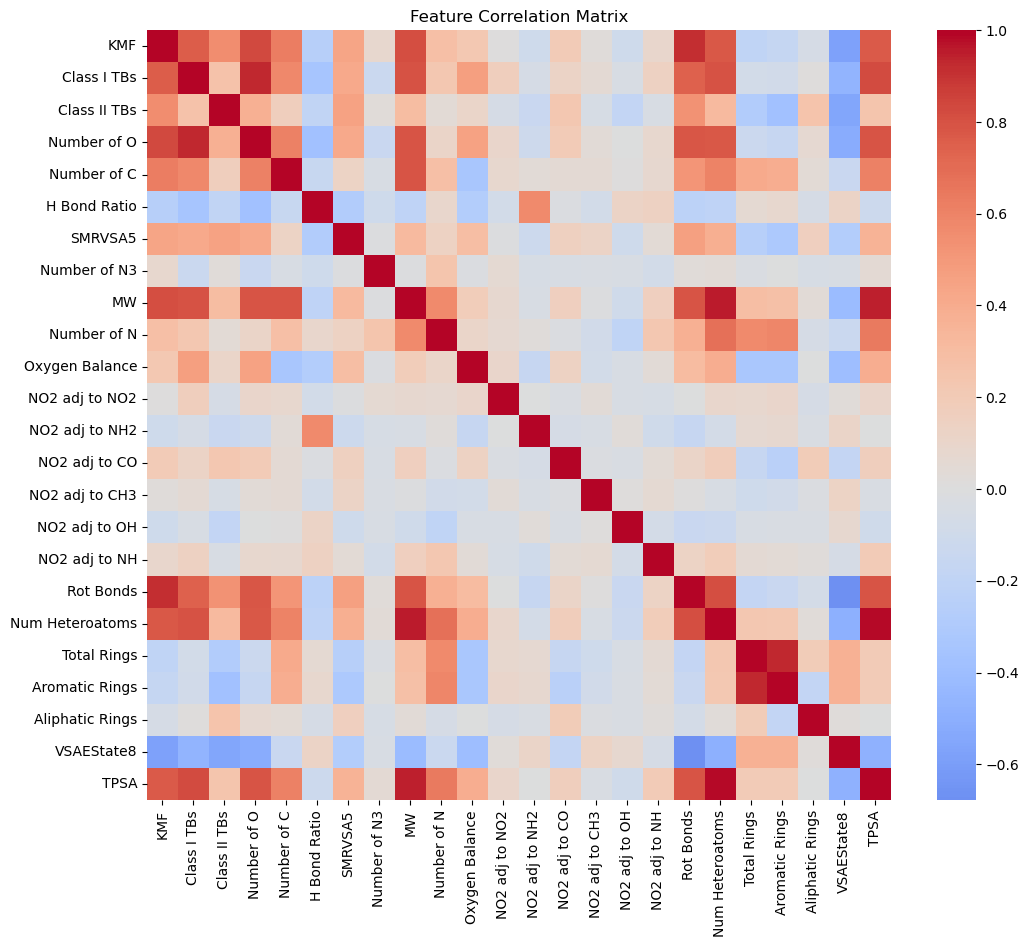

In [8]:
corr_matrix = features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

In [9]:
# Take upper triangle of correlation matrix to avoid duplicate pairs
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Print feature pairs with absolute correlation > 0.8 or < -0.8
high_corr_pairs = [(col, row, corr_matrix.loc[row, col]) 
                   for col in upper_tri.columns 
                   for row in upper_tri.index 
                   if abs(upper_tri.loc[row, col]) > 0.8]

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
for f1, f2, corr in high_corr_pairs:
    print(f"{f1} ↔ {f2} : {corr:.2f}")


Highly correlated feature pairs (|correlation| > 0.8):
Number of O ↔ KMF : 0.83
Number of O ↔ Class I TBs : 0.93
MW ↔ KMF : 0.81
MW ↔ Class I TBs : 0.80
Rot Bonds ↔ KMF : 0.91
Num Heteroatoms ↔ Class I TBs : 0.80
Num Heteroatoms ↔ MW : 0.95
Num Heteroatoms ↔ Rot Bonds : 0.81
Aromatic Rings ↔ Total Rings : 0.93
TPSA ↔ Class I TBs : 0.82
TPSA ↔ MW : 0.94
TPSA ↔ Num Heteroatoms : 0.98


#### Columns to be dropped by discussion:

In [10]:
to_drop = ['MW', 'Number of O', 'Rot Bonds', 'Num Heteroatoms', 'Total Rings']
df_reduced = features.drop(columns=to_drop)

In [11]:
print("Dropped columns due to high correlation:")
print(to_drop)

Dropped columns due to high correlation:
['MW', 'Number of O', 'Rot Bonds', 'Num Heteroatoms', 'Total Rings']


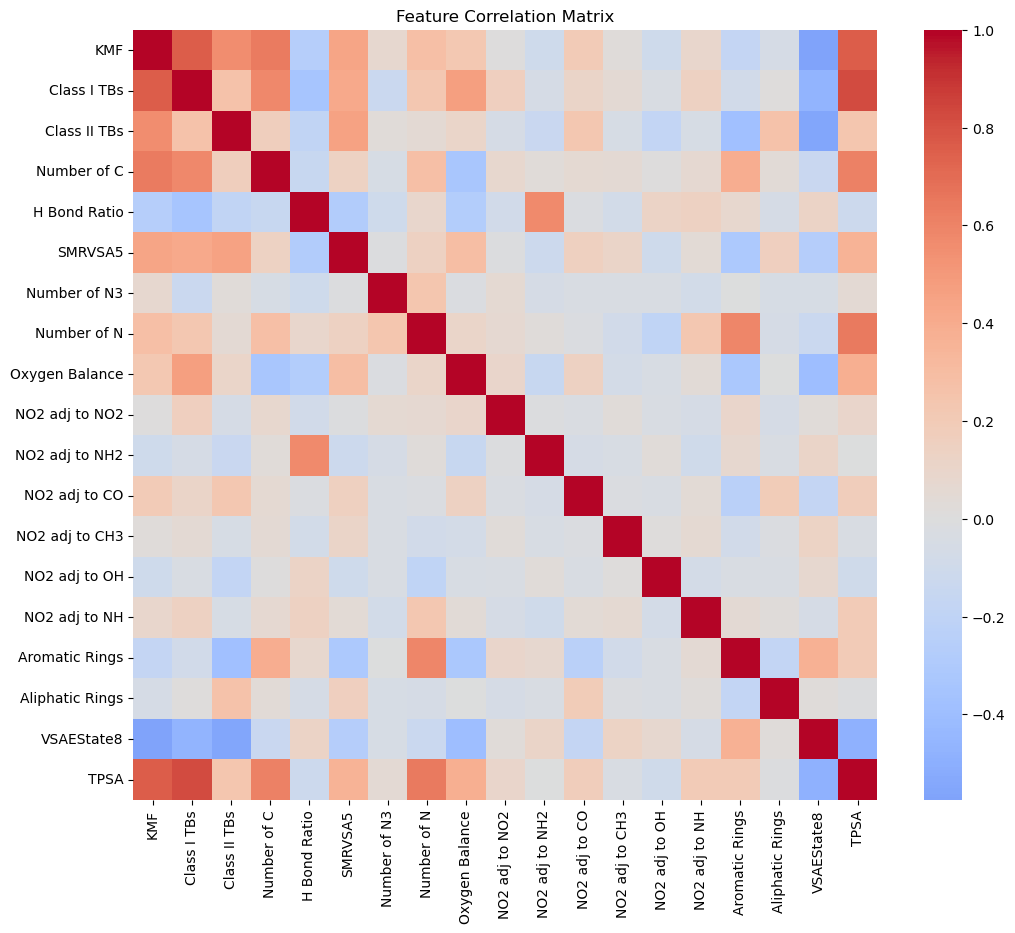

In [12]:
corr_matrix = df_reduced.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

## Hyperparameter Tuning & Models

LinSVC, LogReg, RF, LightGBM

In [13]:
features = df_reduced

In [14]:
# read in target sensitivity classification values
targetvalues = pd.read_excel('targets.xlsx')
# convert to a NumPy array & select desired column
binarytarget = targetvalues.iloc[:, 0].to_numpy()

In [15]:
targets=['binary','tertiary','quaternary','quintenary']

In [16]:
X_train, X_test, y_dummy_train, y_dummy_test = train_test_split(features, targetvalues[targets[0]], test_size=0.25, random_state=0)


In [17]:
train_idx = X_train.index
test_idx = X_test.index

In [18]:
y_train_dict = {target: targetvalues.loc[train_idx, target] for target in targets}
y_test_dict = {target: targetvalues.loc[test_idx, target] for target in targets}


### MinMax Scaling

In [19]:
columns_to_scale = ['KMF', 'Class I TBs', 'Class II TBs', 'Number of N3', 'MW', 'H Bond Ratio',
       'Oxygen Balance', 'Num Heteroatoms', 'Total Rings', 'Aromatic Rings', 'Aliphatic Rings', 'SMRVSA5', 'TPSA', 
                                   'Rot Bonds','VSAEState8', 'Number of N']

In [20]:
columns_to_scale = [x for x in columns_to_scale if x not in to_drop]

In [21]:
transformer = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Leave all other columns untouched
)

X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [22]:
other_features = [col for col in features.columns if col not in columns_to_scale]

In [23]:
all_feature_names = columns_to_scale + other_features

In [24]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = all_feature_names, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = all_feature_names, index = X_test.index)

In [25]:
rename_columns = {"SMRVSA5": "SMR_VSA5",
                              "VSAEState8": "VSA_EState8",
                              "Number of N3" : "Number of N\u2083",
                              "NO2 adj to NO2": "NO\u2082 adj to NO\u2082",
                              "NO2 adj to NH2": "NO\u2082 adj. to NH\u2082",
                              "NO2 adj to CO": "NO\u2082 adj. to CO",
                             "NO2 adj to CH3": "NO\u2082 adj. to CH\u2083",
                              "NO2 adj to OH":"NO\u2082 adj to OH",
                              "NO2 adj to NH":"NO\u2082 adj to NH",
                              "Aromatic Rings":"No. of Aromatic Rings",
                               "Aliphatic Rings":"No. of Aliphatic Rings"}

In [26]:
X_train_scaled.rename(columns=rename_columns, inplace=True)
X_test_scaled.rename(columns=rename_columns, inplace=True)

In [27]:
X = pd.concat([X_train_scaled, X_test_scaled], axis = 0)

In [54]:
X.head()

KMF  Class I TBs  Class II TBs  Number of N₃  H Bond Ratio  \
412  0.032890     0.000000      0.000000           0.0      0.344794   
400  0.791010     1.000000      0.000000           0.0      0.000000   
160  0.723204     0.803545      0.698555           0.0      0.000000   
220  0.418719     0.216618      0.540476           0.0      0.000000   
49   0.124360     0.216618      0.000000           0.0      0.090424   

     Oxygen Balance  No. of Aromatic Rings  No. of Aliphatic Rings  SMR_VSA5  \
412        0.641438                   0.25                     0.0  0.000000   
400        0.468206                   1.00                     0.0  0.000000   
160        0.802651                   0.00                     0.0  0.664824   
220        0.465389                   0.25                     0.0  0.695873   
49         0.603682                   0.25                     0.0  0.000000   

         TPSA  VSA_EState8  Number of N  Number of C  NO₂ adj to NO₂  \
412  0.101912     0.724917     0.157895     1.098612             0.0   
400  1.000000     0.724917     0.578947     3.218876             0.0   
160  0.693519     0.204518     0.473684     2.079442             0.0   
220  0.161923     0.699922     0.210526     1.791759             0.0   
49   0.116997     0.724917     0.157895     1.386294             0.0   

     NO₂ adj. to NH₂  NO₂ adj. to CO  NO₂ adj. to CH₃  NO₂ adj to OH  \
412              1.0             0.0              0.0            0.0   
400              0.0             0.0              0.0            0.0   
160              0.0             1.0              0.0            0.0   
220              0.0             0.0              0.0            0.0   
49               0.0             0.0              0.0            0.0   

     NO₂ adj to NH  
412            0.0  
400            0.0  
160            0.0  
220            0.0  
49             1.0

## Tuning

### Linear SVC

These sections conduct a grid search to find the best values of the hyperparameters for each model & task

In [28]:
svc_params = {}
for target in targets:
    svc_params[target] = tune_svc(X_train_scaled, y_train_dict[target],target)

Best score for binary: 0.7303652968036529
Best score for tertiary: 0.5427701674277017
Best score for quaternary: 0.44067732115677316
Best score for quintenary: 0.3910958904109589


### Logistic Regression

In [29]:
logreg_params = {}
for target in targets:
    logreg_params[target] = tune_logreg(X_train_scaled, y_train_dict[target],target)

Best score for binary log.reg. : 0.735882800608828
Best score for tertiary log.reg. : 0.5566590563165906
Best score for quaternary log.reg. : 0.4488584474885844
Best score for quintenary log.reg. : 0.3940258751902587


### Random Forests

Skip this and go to optional load step if you don't want to run the whole thing again

In [29]:
rf_params = {}
for target in targets:
    rf_params[target] = tune_rf(X_train_scaled, y_train_dict[target],target, rf_param_grid)

Best score for binary RF : 0.7797945205479453
Best score for tertiary RF : 0.5895738203957382
Best score for quaternary RF : 0.4877853881278539
Best score for quintenary RF : 0.4104642313546424


### LightGBM

In [30]:
space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.uniform('max_depth', 4, 10)
}

In [31]:
lightgb_params = {}
for target in targets:
    lightgb_params[target] = tune_lgbm(X_train_scaled, y_train_dict[target], target, space)

binary lightgbm:
100%|████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.80trial/s, best loss: 0.7439878234398781]
tertiary lightgbm:
100%|████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/trial, best loss: 0.5374048706240486]
quaternary lightgbm:
100%|███████████████████████████████████████████████| 50/50 [01:32<00:00,  1.84s/trial, best loss: 0.41343226788432264]
quintenary lightgbm:
100%|████████████████████████████████████████████████| 50/50 [02:04<00:00,  2.49s/trial, best loss: 0.3777397260273972]


##### Optional: Save or Load params

In [32]:
# # Good to save time with future runs of same params: specially for RF/LGBM which can save a few mins
# with open('rf_params_red_features_correct_data.pkl', 'wb') as f:
#     pickle.dump(rf_params, f)

# with open('lgbm_params_red_features_correct_data.pkl', 'wb') as f:
#     pickle.dump(lightgb_params, f)

In [30]:
with open('rf_params_red_features_correct_data.pkl', 'rb') as f:
    rf_params = pickle.load(f)

with open('lgbm_params_red_features_correct_data.pkl', 'rb') as f:
    lightgb_params = pickle.load(f)

## Models Run

### Linear SVC

SVC (binary) Training set score: 0.752
SVC (binary) Test set score: 0.779
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        47
           1       0.83      0.80      0.82        75

    accuracy                           0.78       122
   macro avg       0.77      0.77      0.77       122
weighted avg       0.78      0.78      0.78       122

SVC (tertiary) Training set score: 0.636
SVC (tertiary) Test set score: 0.598
              precision    recall  f1-score   support

           0       0.58      0.63      0.60        35
           1       0.52      0.34      0.41        44
           2       0.65      0.84      0.73        43

    accuracy                           0.60       122
   macro avg       0.58      0.60      0.58       122
weighted avg       0.58      0.60      0.58       122

SVC (quaternary) Training set score: 0.551
SVC (quaternary) Test set score: 0.410
              precision    recall  f1-score   support

   

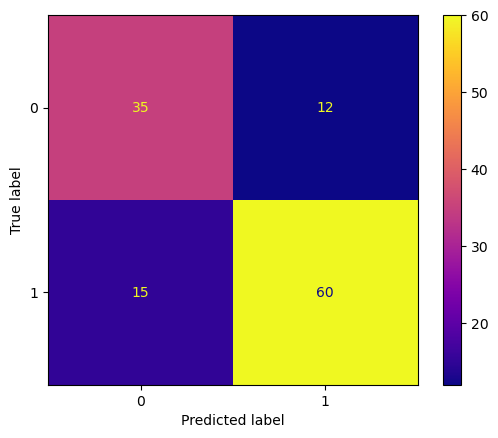

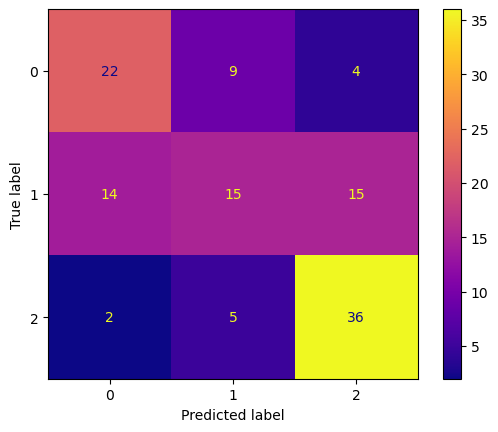

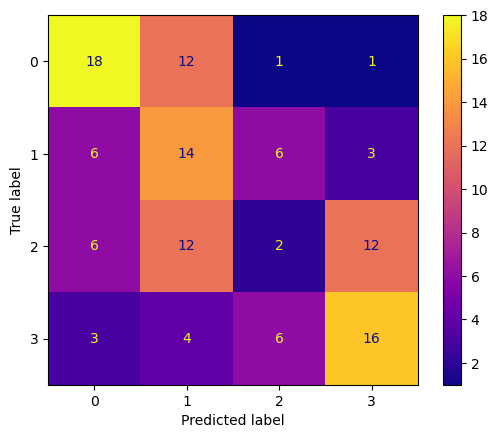

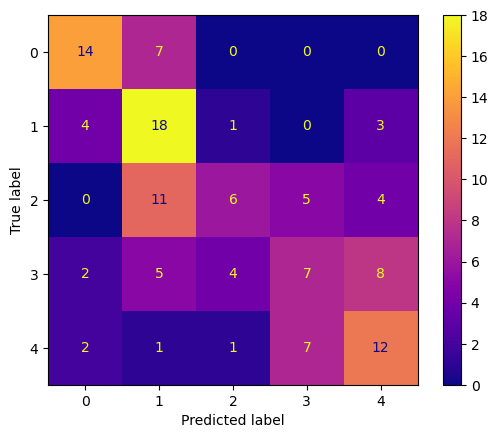

In [31]:
svc_models = {}
for target in targets:
    svc_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], svc_params, target, 'SVC')

### Logistic Regression

C:\Users\katri\miniconda3\envs\chem\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\katri\miniconda3\envs\chem\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\katri\miniconda3\envs\chem\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg (binary) Training set score: 0.741
LogReg (binary) Test set score: 0.779
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        47
           1       0.82      0.81      0.82        75

    accuracy                           0.78       122
   macro avg       0.77      0.77      0.77       122
weighted avg       0.78      0.78      0.78       122

AUC-ROC (macro): 0.830
AUC-ROC (weighted): 0.830
LogReg (tertiary) Training set score: 0.642
LogReg (tertiary) Test set score: 0.639
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        35
           1       0.58      0.48      0.53        44
           2       0.67      0.77      0.72        43

    accuracy                           0.64       122
   macro avg       0.64      0.64      0.64       122
weighted avg       0.63      0.64      0.63       122

AUC-ROC (macro): 0.786
AUC-ROC (weighted): 0.780
LogReg (quaternary) Training s

C:\Users\katri\miniconda3\envs\chem\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


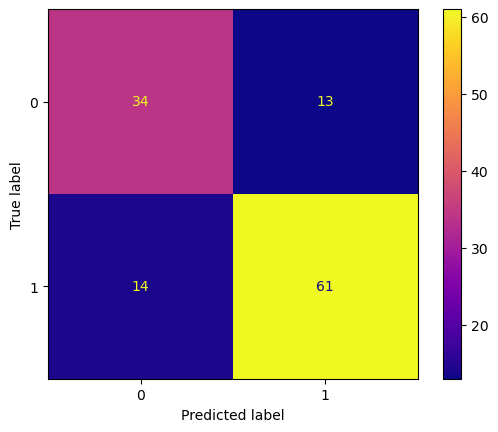

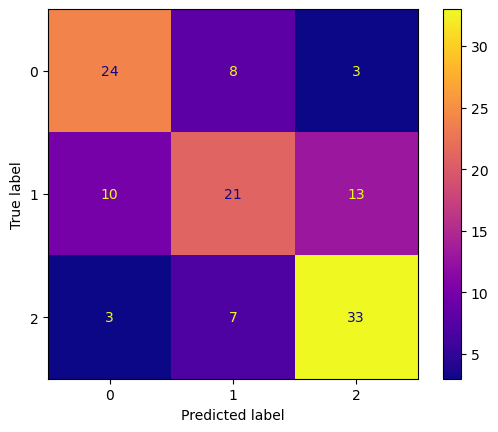

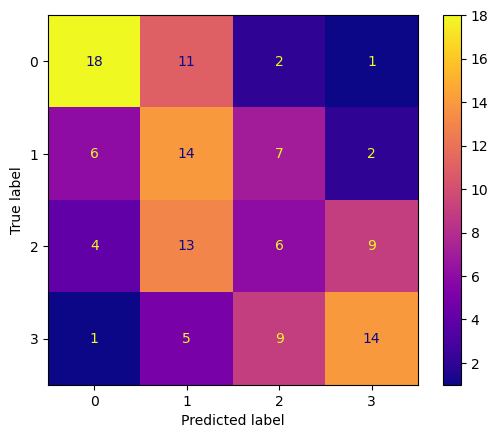

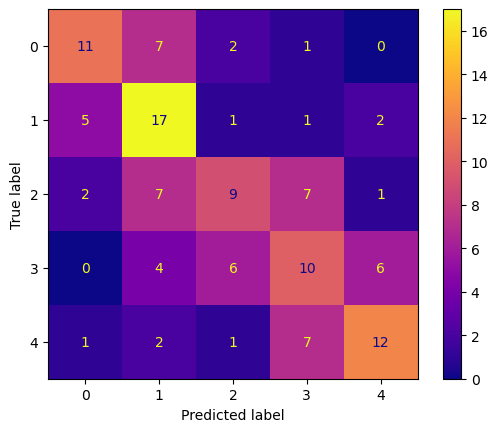

In [32]:
logreg_models = {}
for target in targets:
    logreg_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], logreg_params, target, 'LogReg')

### Random Forests

##### Run RF:

RandomForest (binary) Training set score: 0.948
RandomForest (binary) Test set score: 0.787
              precision    recall  f1-score   support

           0       0.73      0.70      0.72        47
           1       0.82      0.84      0.83        75

    accuracy                           0.79       122
   macro avg       0.78      0.77      0.77       122
weighted avg       0.79      0.79      0.79       122

AUC-ROC (macro): 0.820
AUC-ROC (weighted): 0.820
RandomForest (tertiary) Training set score: 0.802
RandomForest (tertiary) Test set score: 0.648
              precision    recall  f1-score   support

           0       0.60      0.74      0.67        35
           1       0.58      0.48      0.53        44
           2       0.74      0.74      0.74        43

    accuracy                           0.65       122
   macro avg       0.64      0.65      0.65       122
weighted avg       0.65      0.65      0.64       122

AUC-ROC (macro): 0.834
AUC-ROC (weighted): 0.830
Random

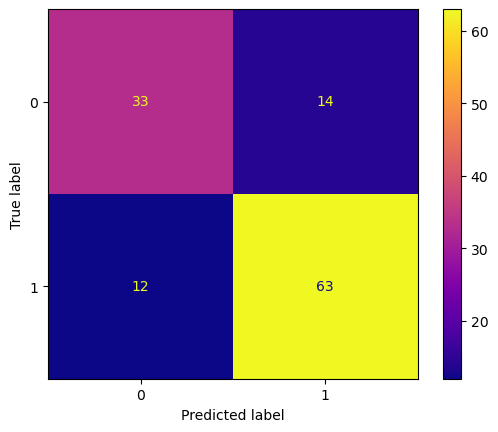

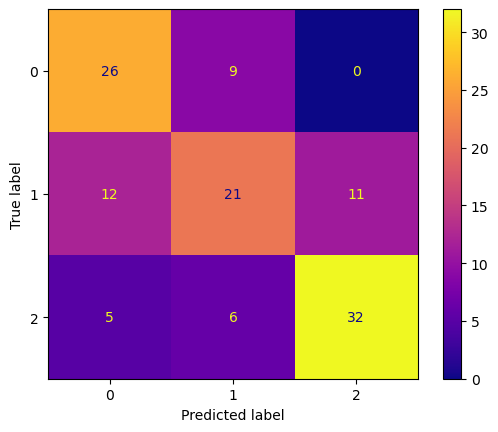

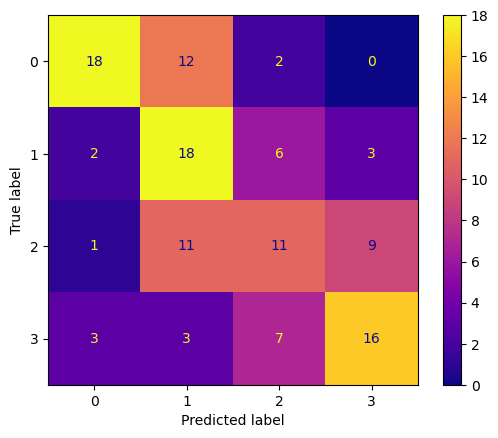

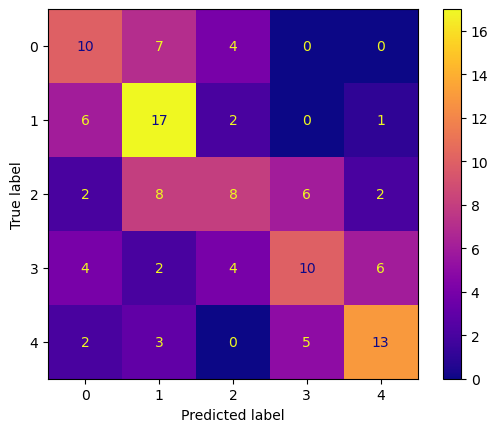

In [33]:
rf_models = {}
for target in targets:
    rf_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], rf_params, target, 'RandomForest')

### LightGBM

LightGBM (binary) Training set score: 1.000
LightGBM (binary) Test set score: 0.779
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        47
           1       0.84      0.79      0.81        75

    accuracy                           0.78       122
   macro avg       0.77      0.78      0.77       122
weighted avg       0.78      0.78      0.78       122

AUC-ROC (macro): 0.820
AUC-ROC (weighted): 0.820
LightGBM (tertiary) Training set score: 0.992
LightGBM (tertiary) Test set score: 0.590
              precision    recall  f1-score   support

           0       0.59      0.66      0.62        35
           1       0.50      0.45      0.48        44
           2       0.67      0.67      0.67        43

    accuracy                           0.59       122
   macro avg       0.59      0.60      0.59       122
weighted avg       0.59      0.59      0.59       122

AUC-ROC (macro): 0.774
AUC-ROC (weighted): 0.769
LightGBM (quaternary) 

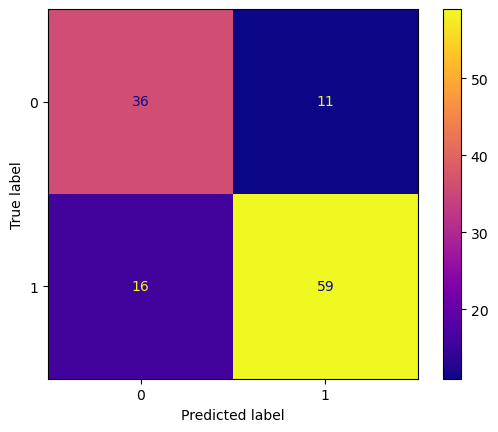

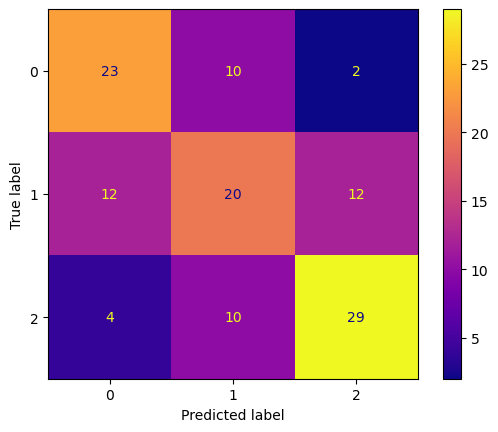

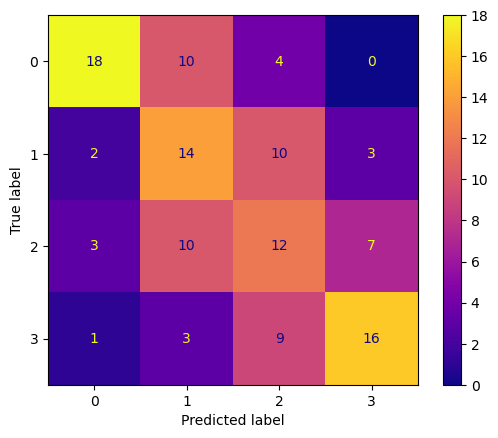

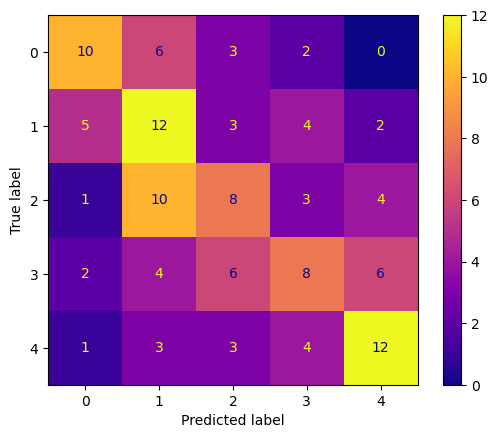

In [34]:
lgb_models = {}
for target in targets:
    objective = 'binary' if target=='binary' else 'multiclass'
    best_params = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": lightgb_params[target]['colsample_bytree'],
    "num_leaves" : int(lightgb_params[target]['num_leaves']),
    'max_depth': int(lightgb_params[target]['max_depth']),
    
    "objective":objective,
    "verbose":-1                  
    }
    lgb_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], best_params, target, 'LightGBM')

### SHAP Plots

#### LogReg

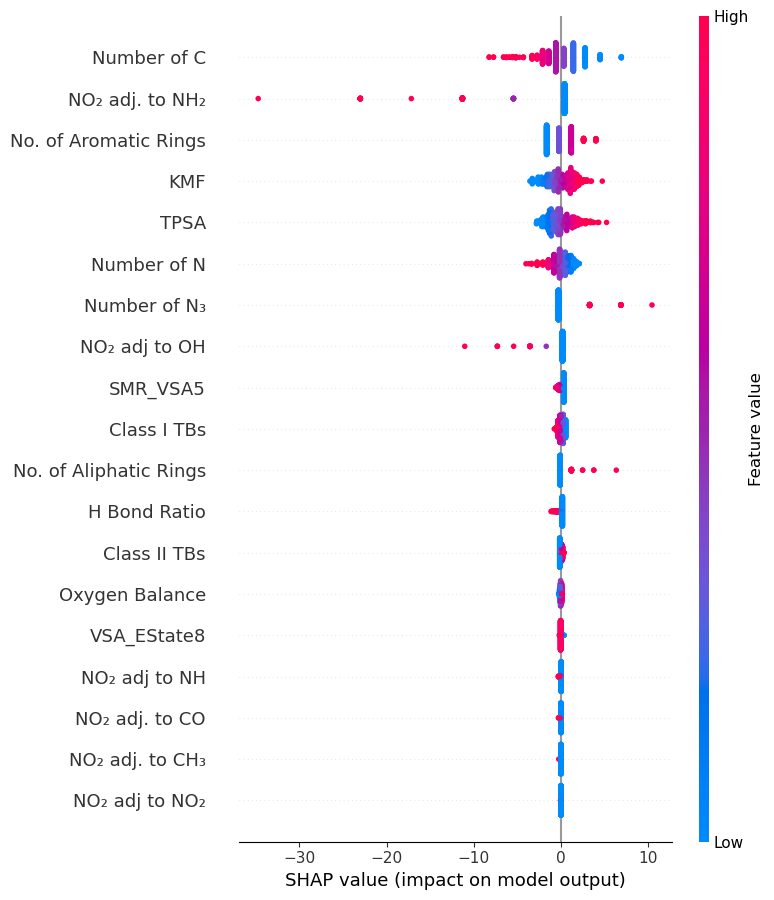

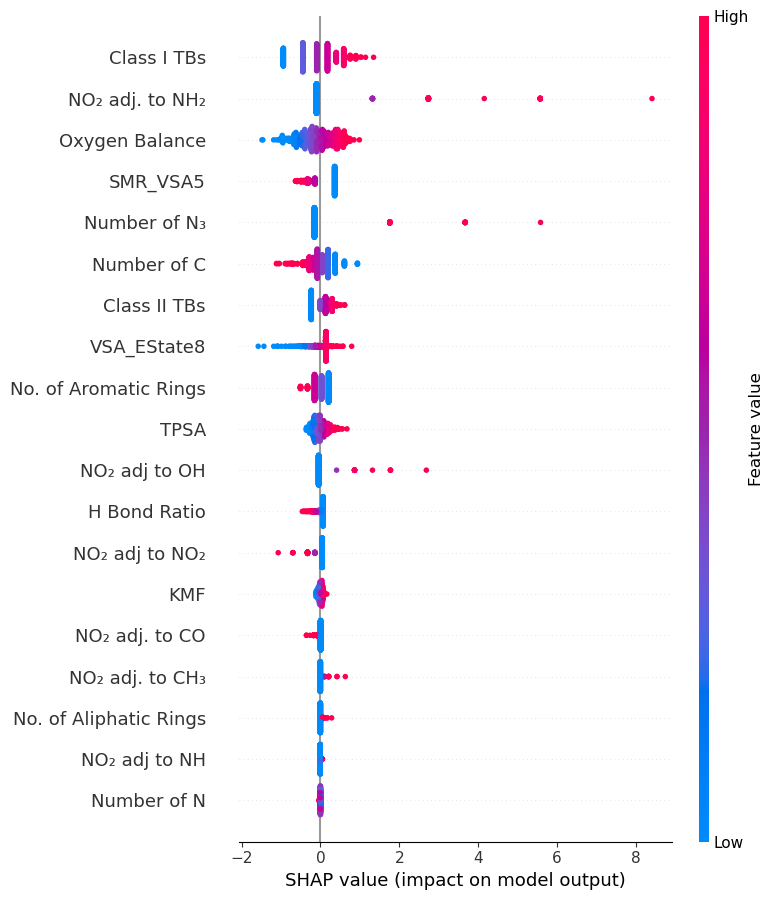

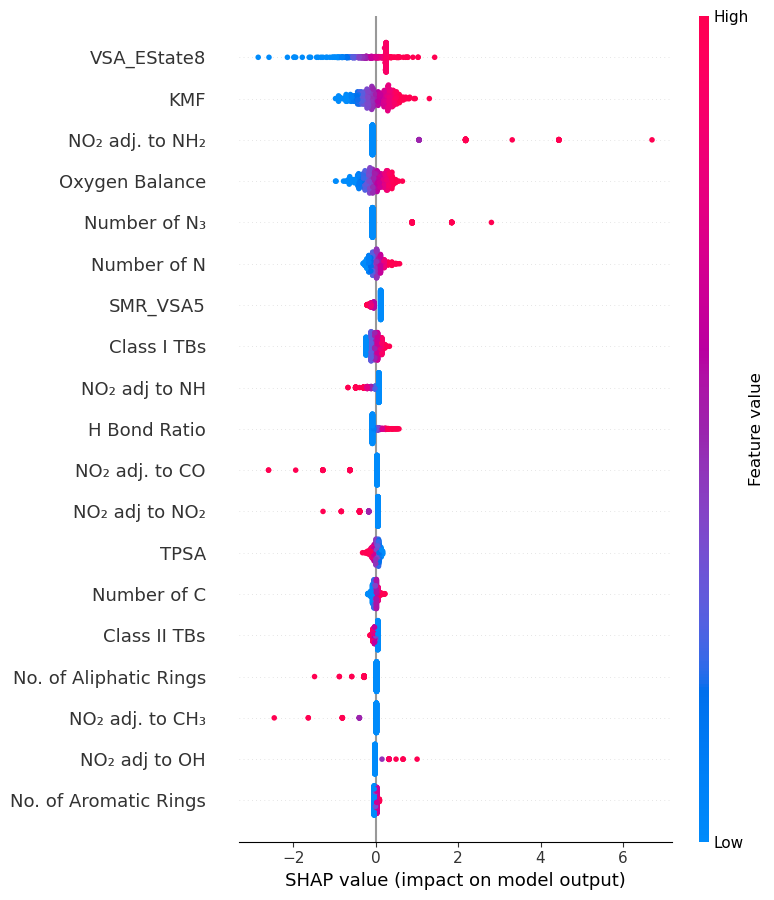

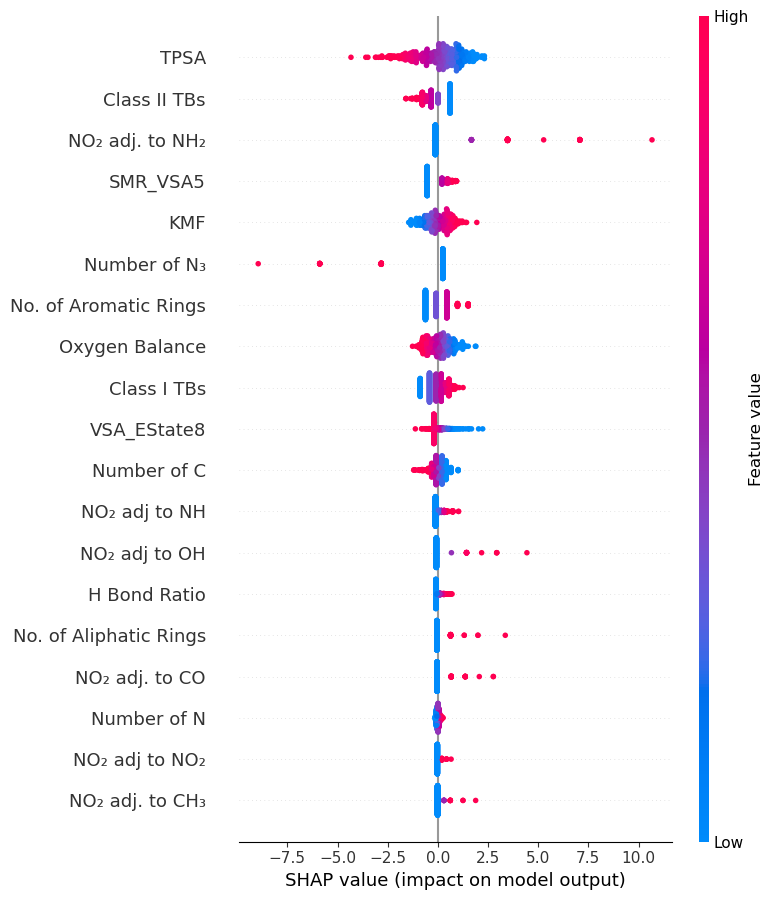

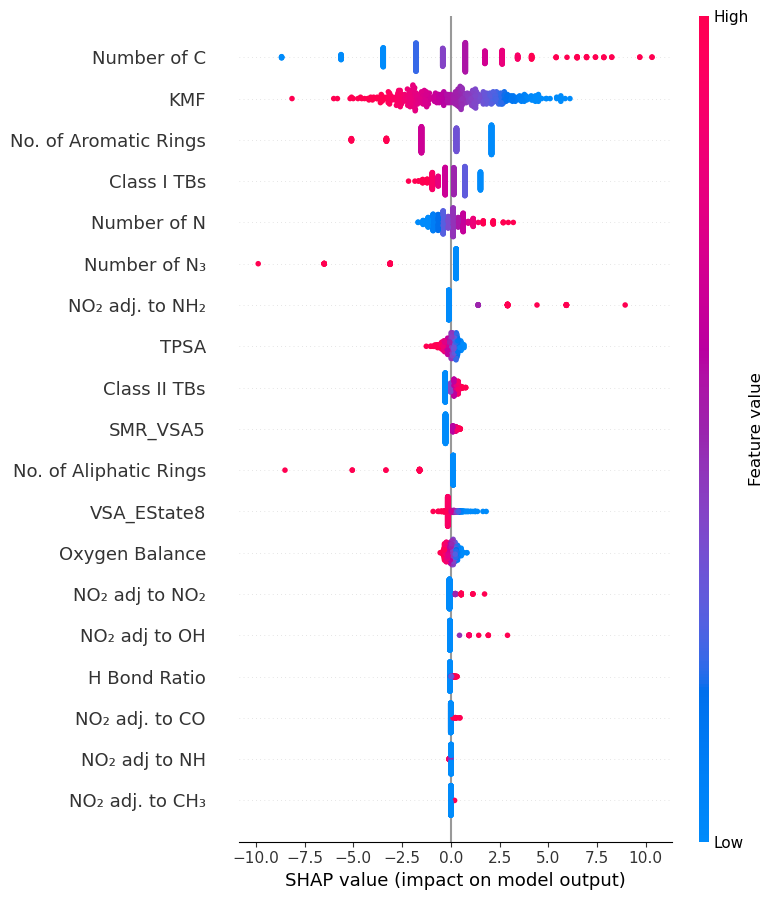

In [35]:
explainer = shap.LinearExplainer(logreg_models['quintenary'], X)
shap_values = explainer(X)
for i in range(0,5):
    shap.summary_plot(shap_values[:,:,i], X)

#### SVC

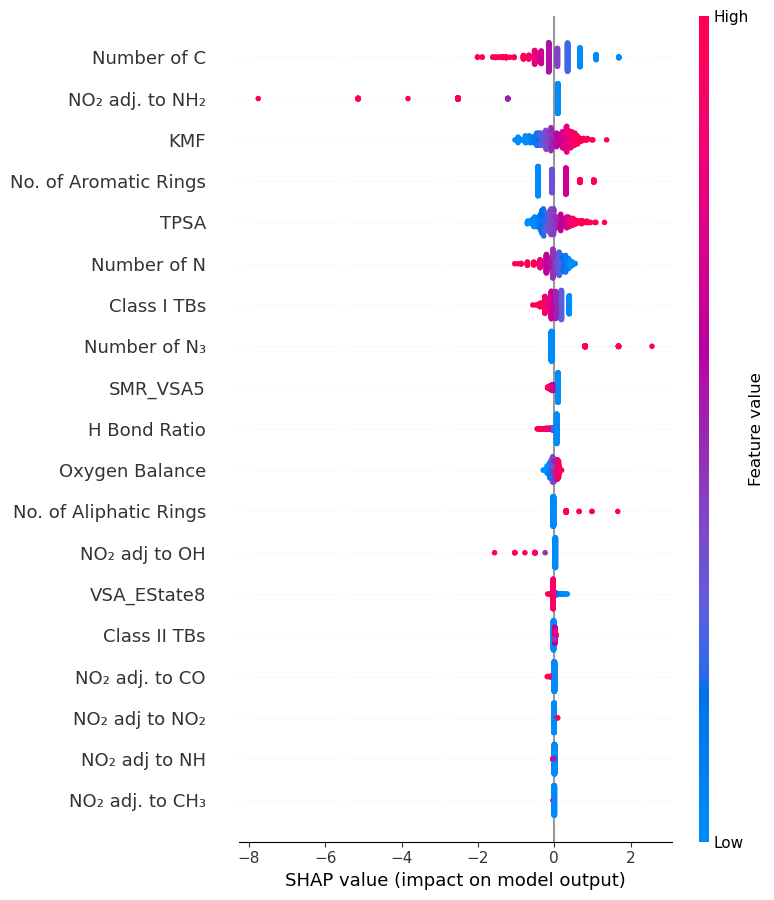

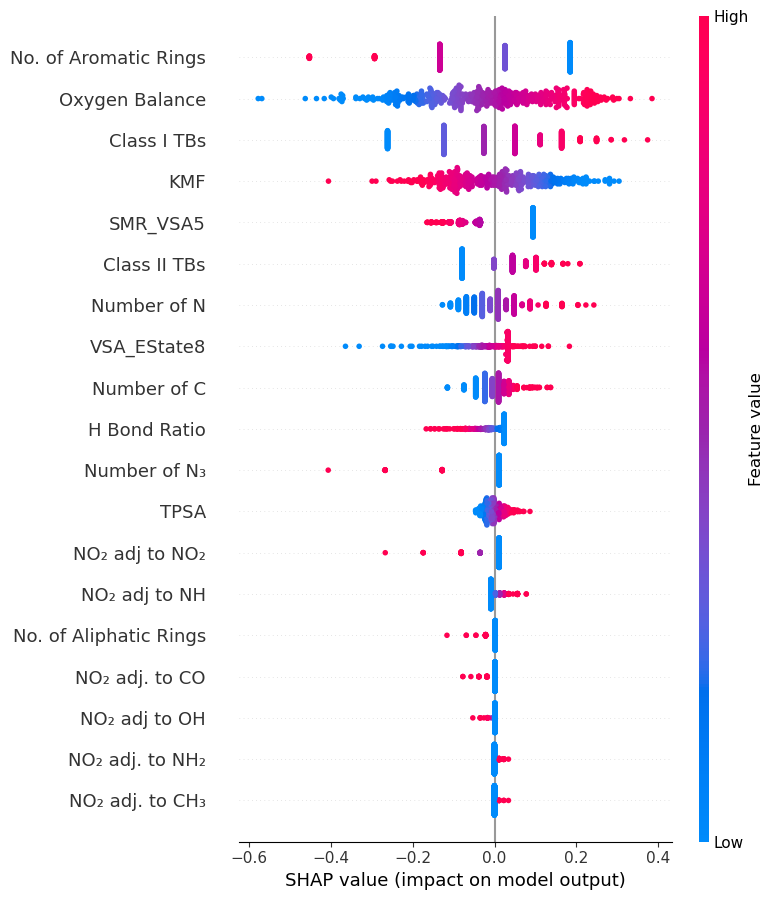

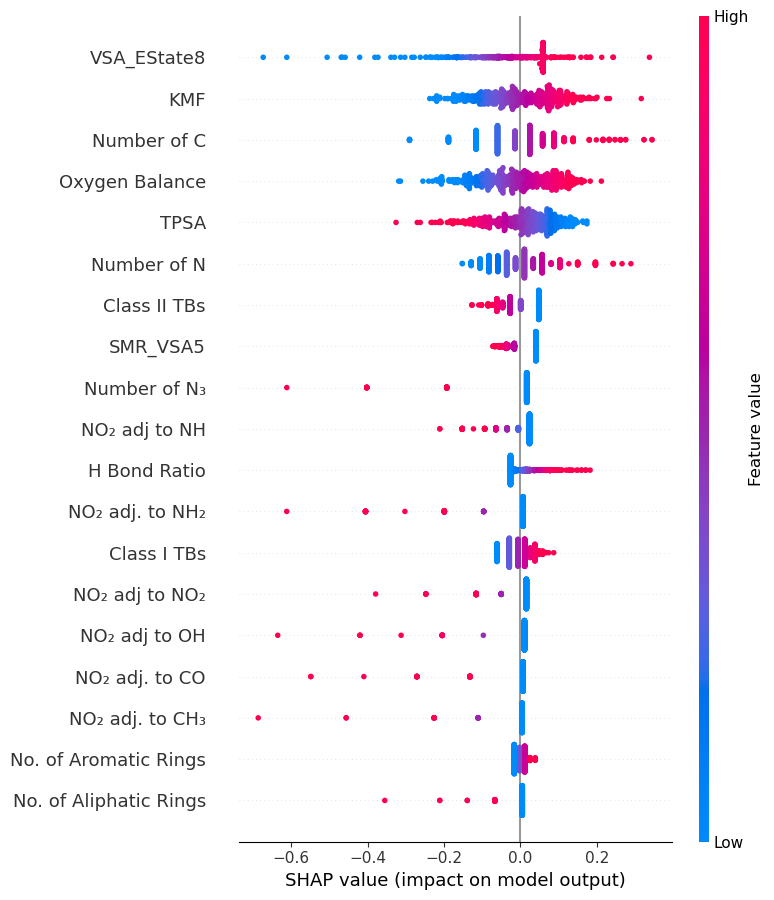

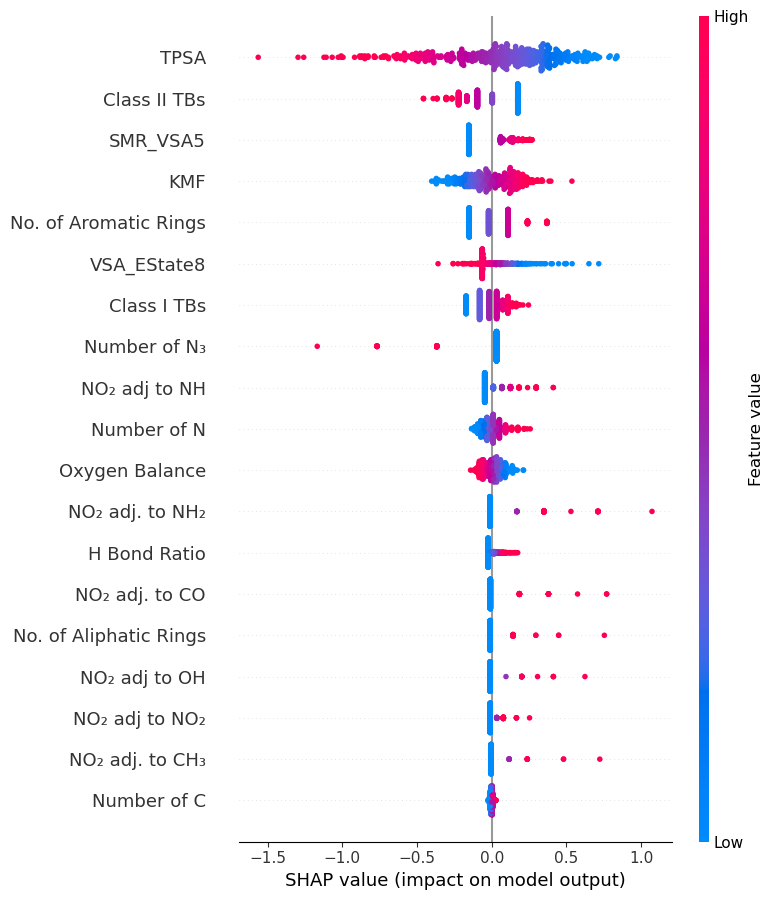

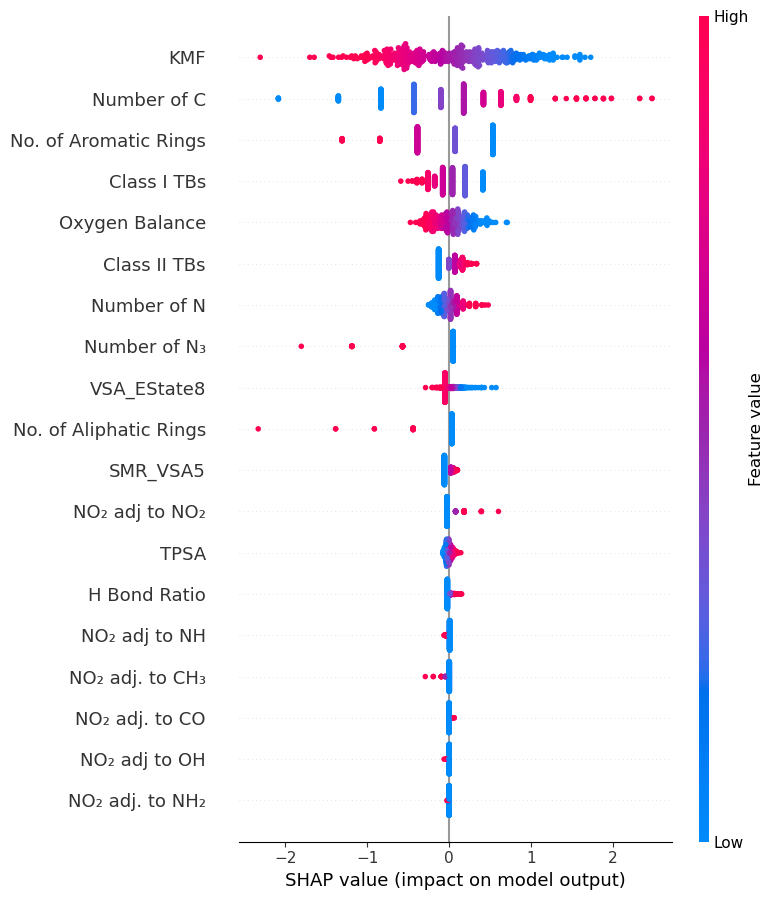

In [36]:
explainer = shap.LinearExplainer(svc_models['quintenary'], X)
shap_values = explainer(X)
for i in range(0,5):
    shap.summary_plot(shap_values[:,:,i], X)

#### Random Forests

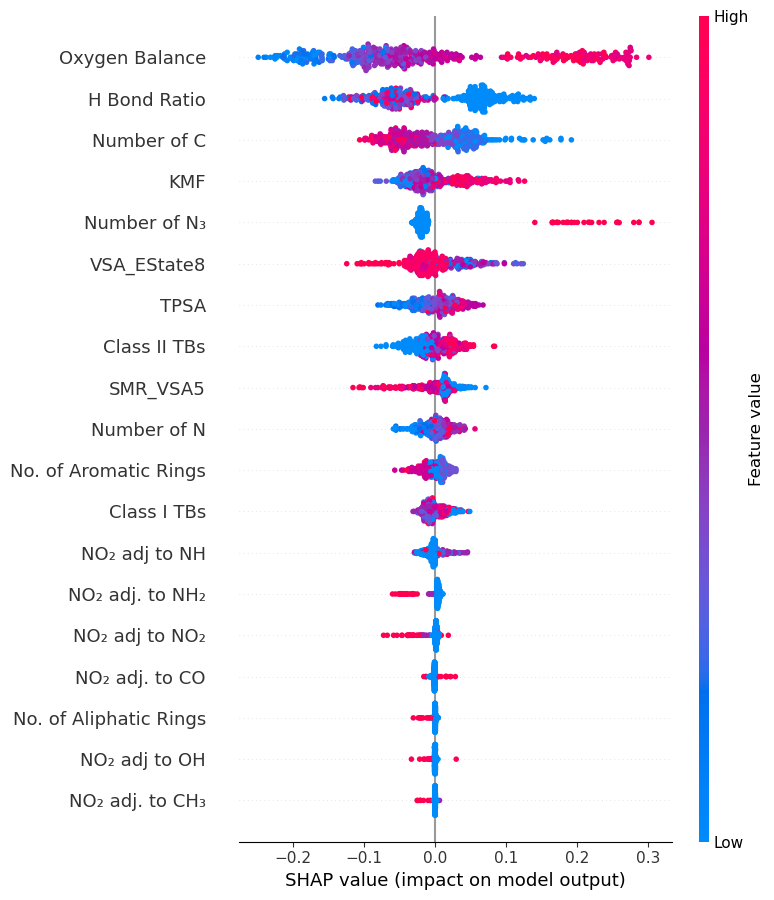

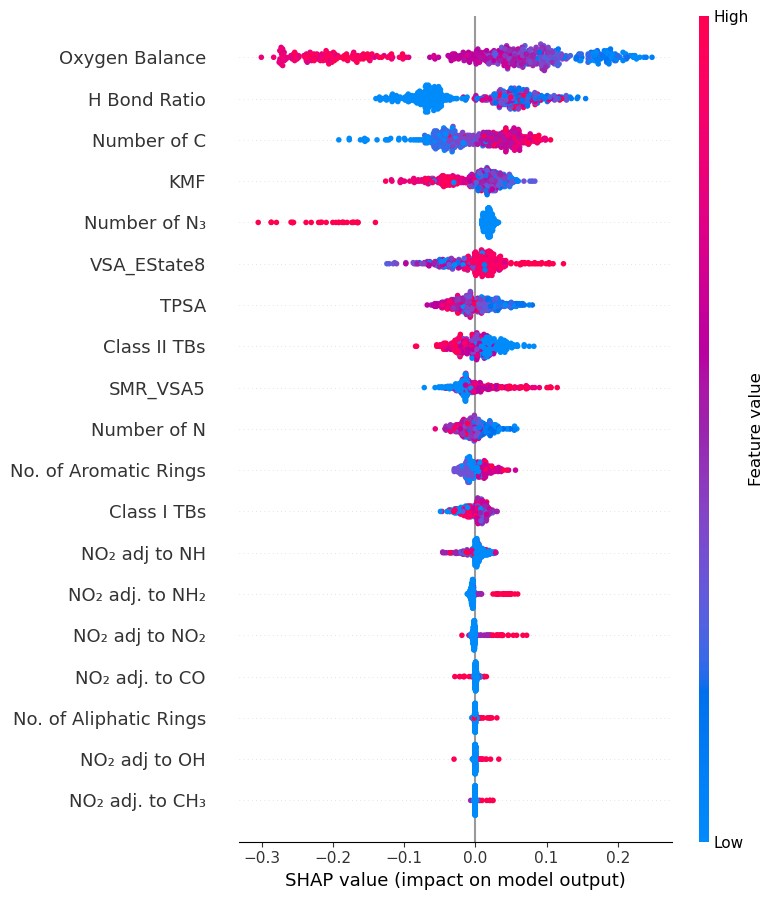

In [37]:
# Binary
explainer = shap.TreeExplainer(rf_models['binary'])
shap_values = explainer(X)
for i in range(0,2):
    shap.summary_plot(shap_values[:,:,i], X)

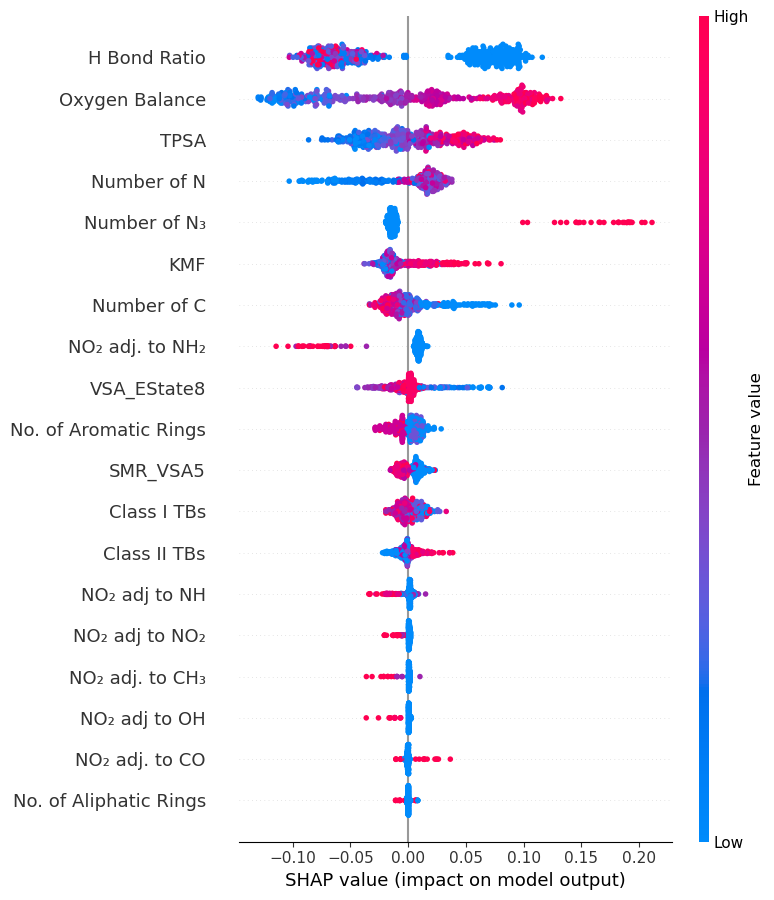

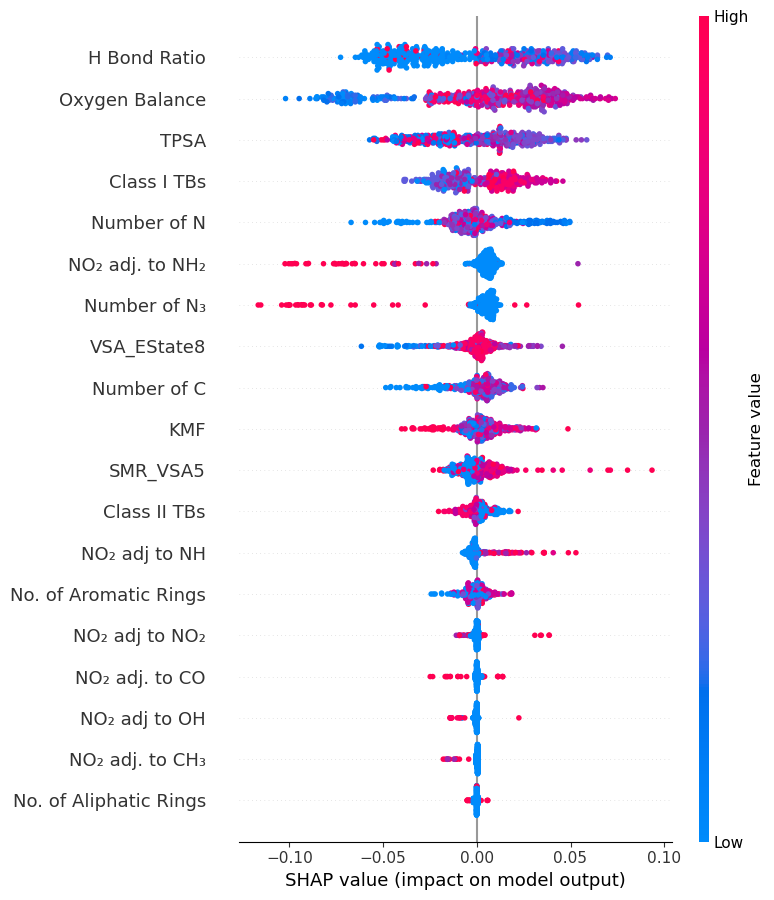

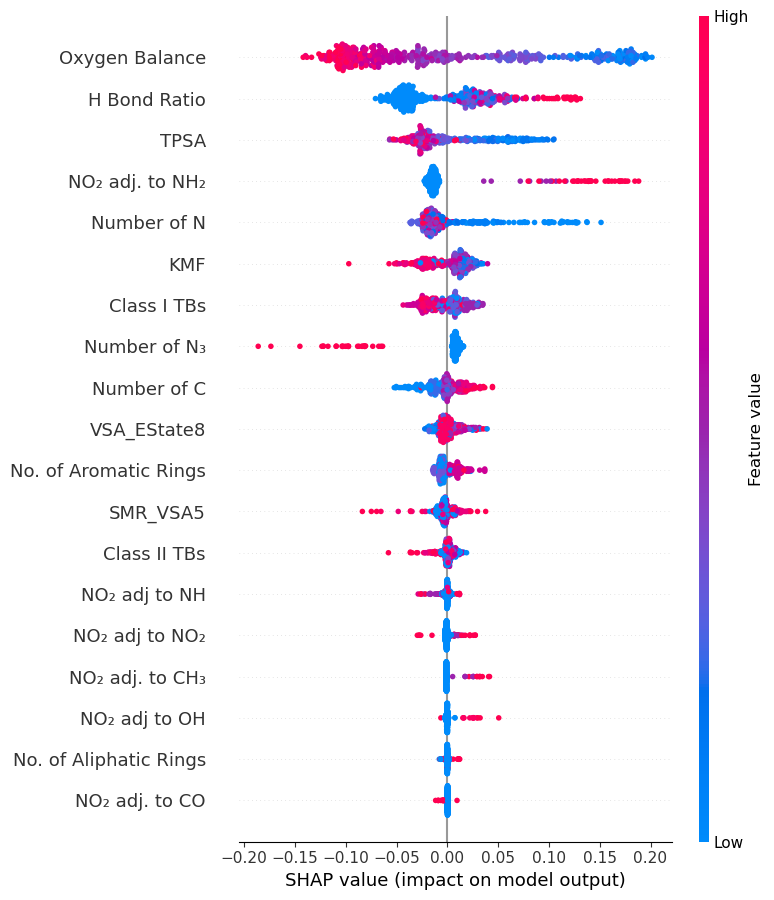

In [39]:
# Tertiary
explainer = shap.TreeExplainer(rf_models['tertiary'])
shap_values = explainer(X)
for i in range(0,3):
    shap.summary_plot(shap_values[:,:,i], X)

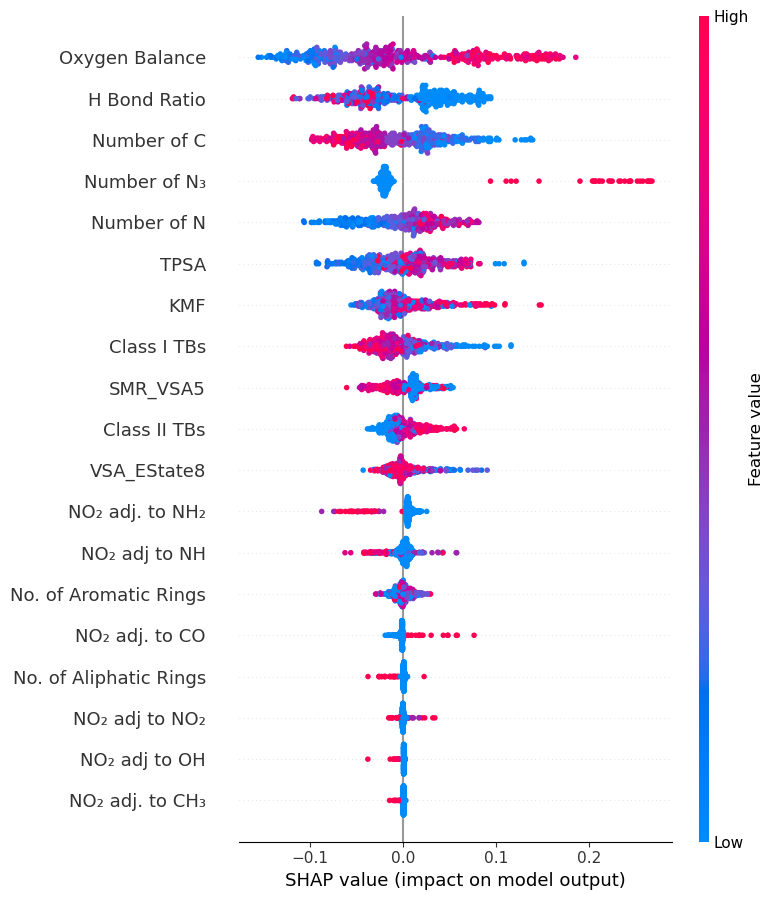

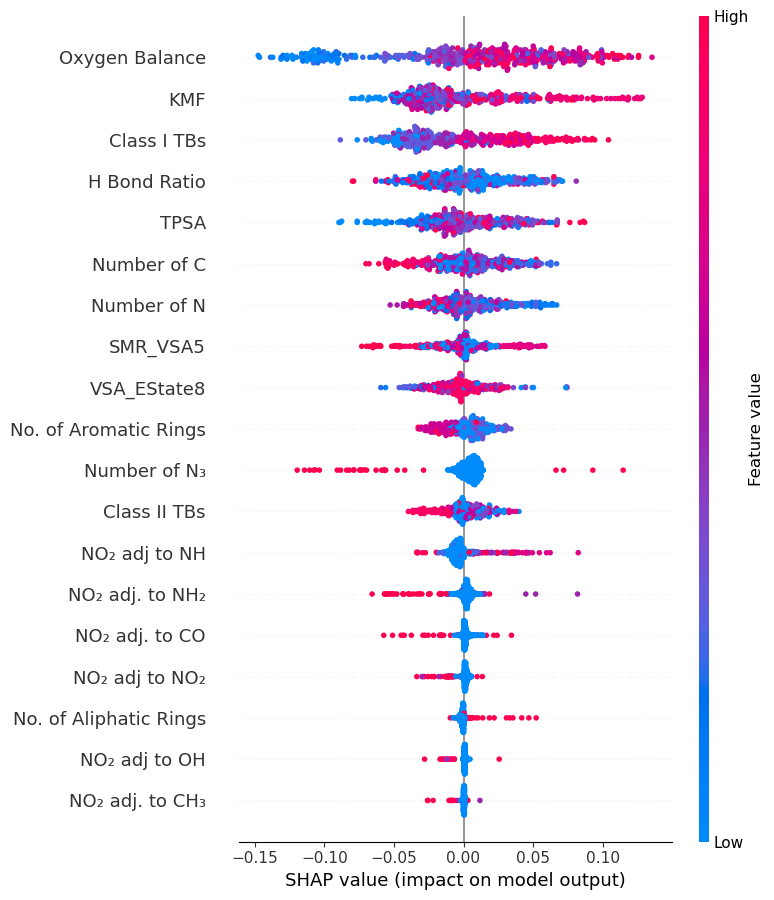

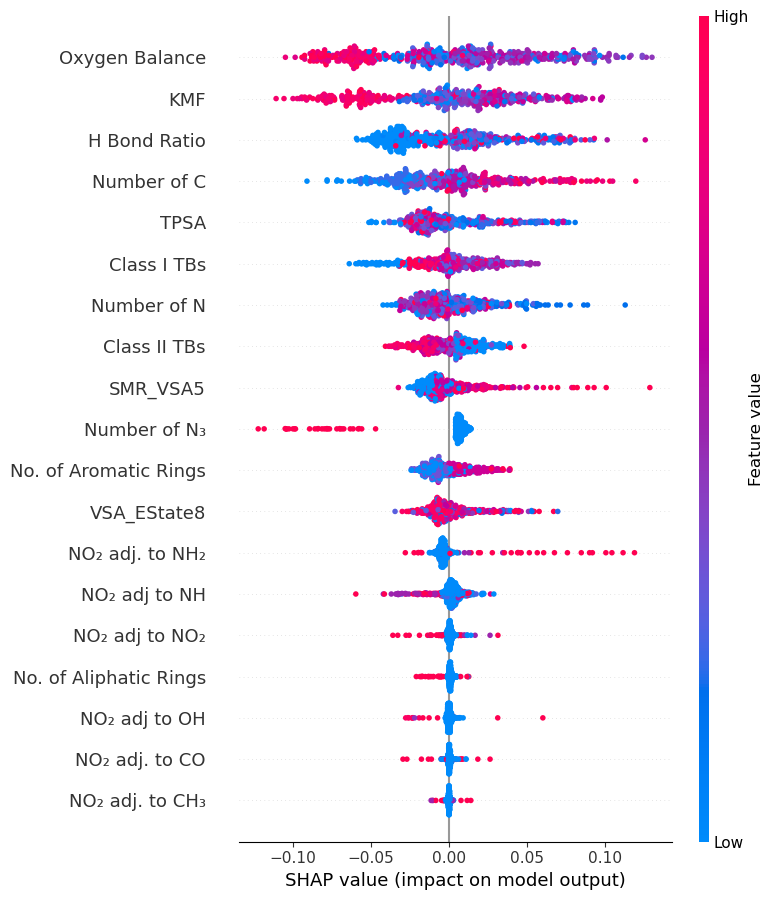

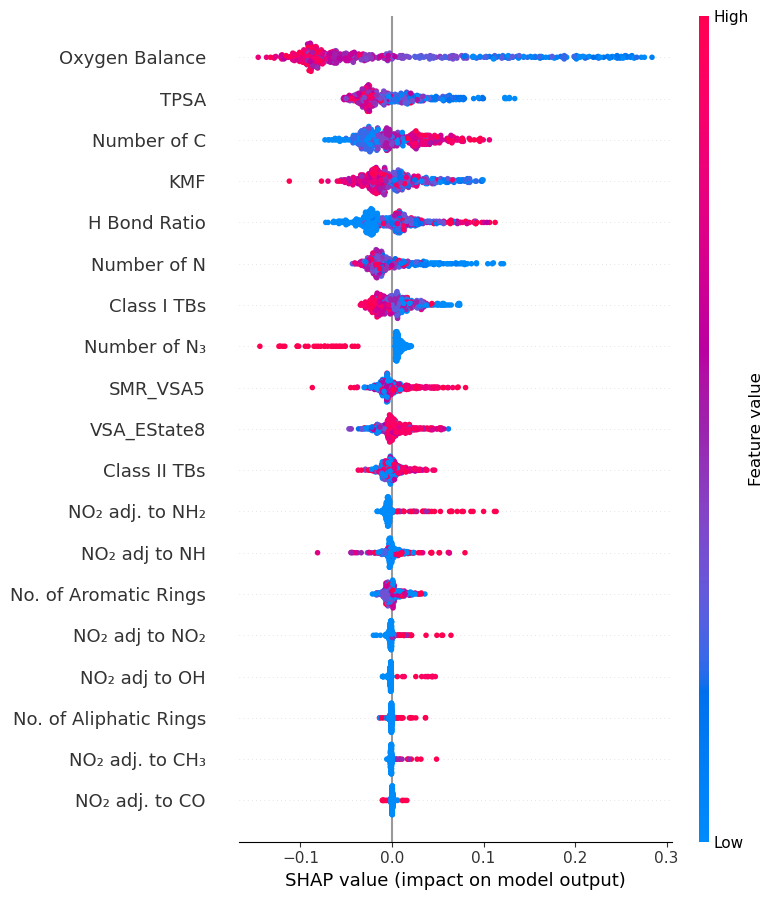

In [53]:
# Tertiary
explainer = shap.TreeExplainer(rf_models['quaternary'])
shap_values = explainer(X)
for i in range(0,4):
    shap.summary_plot(shap_values[:,:,i], X)

#### LightGB

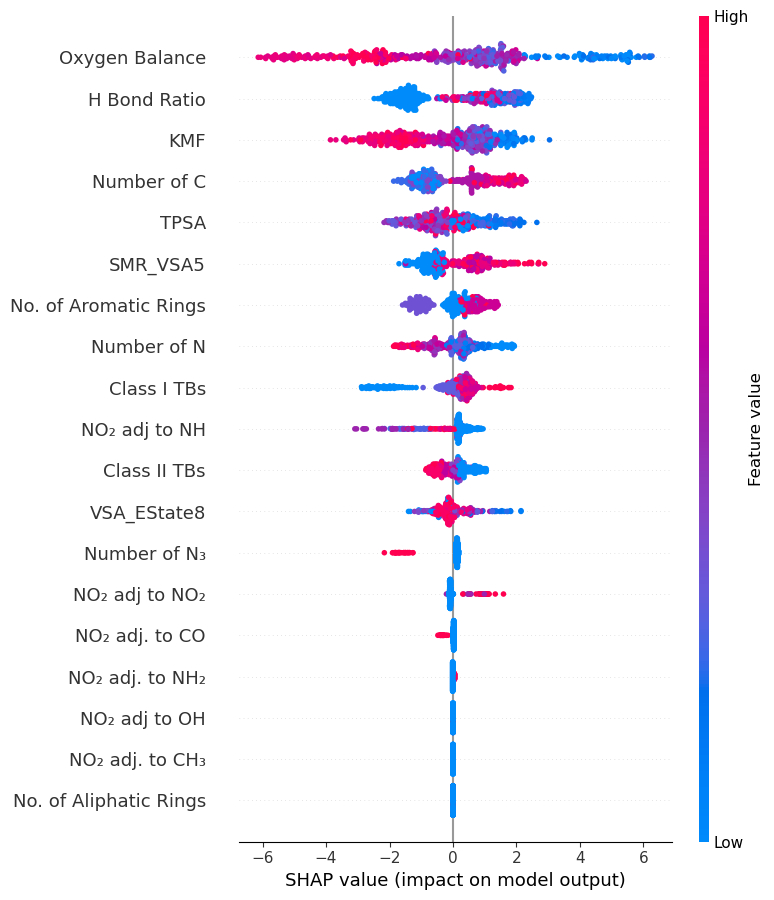

In [40]:
# binary 
explainer = shap.TreeExplainer(lgb_models['binary'])
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

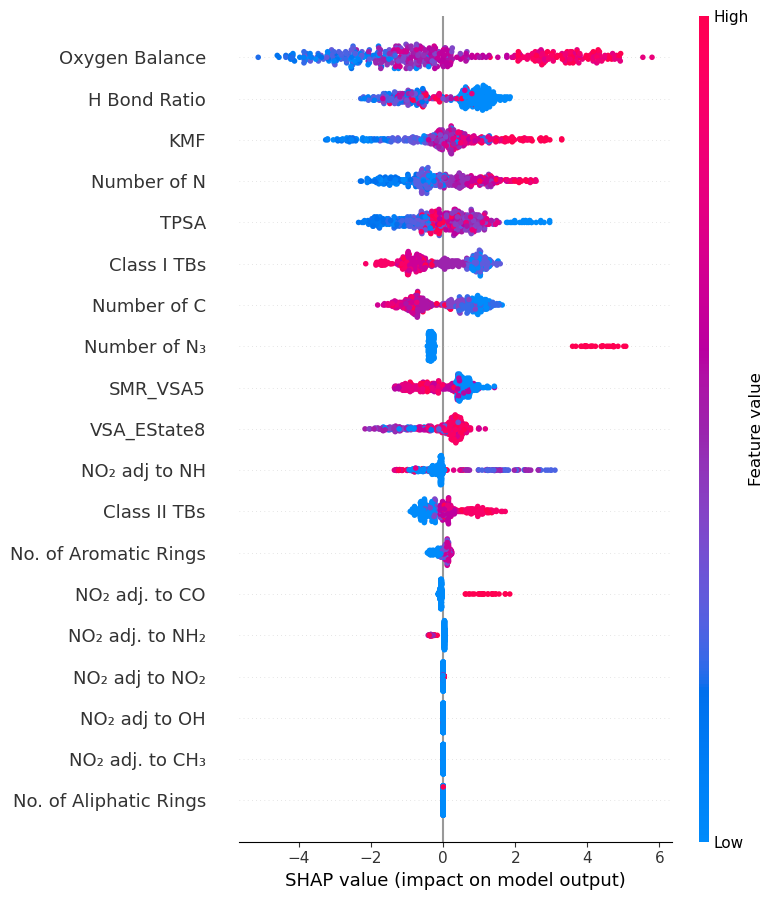

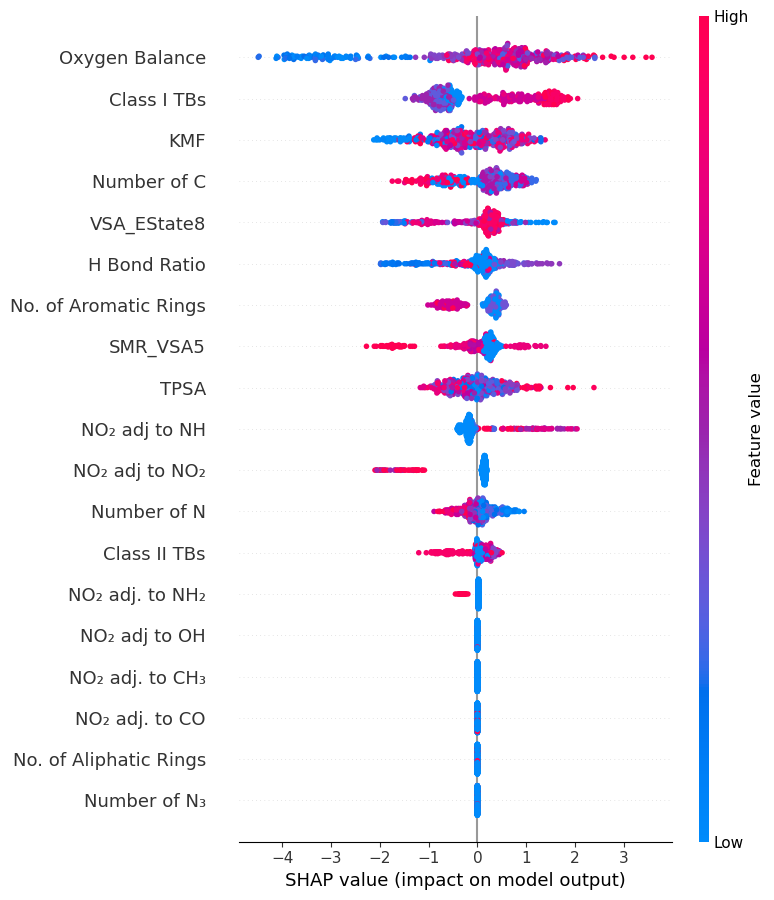

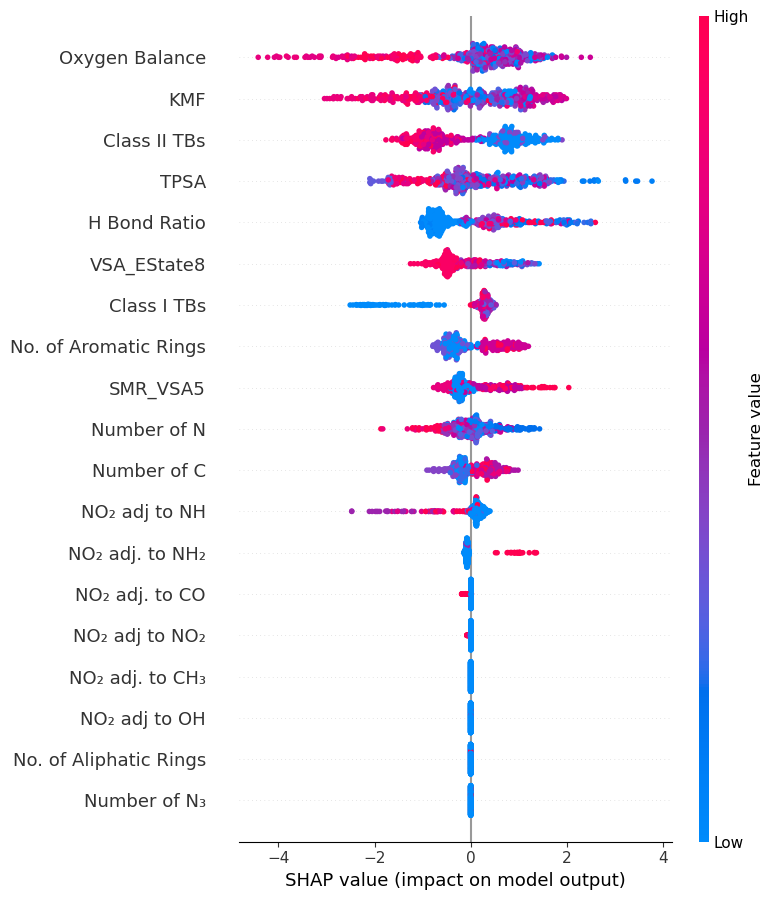

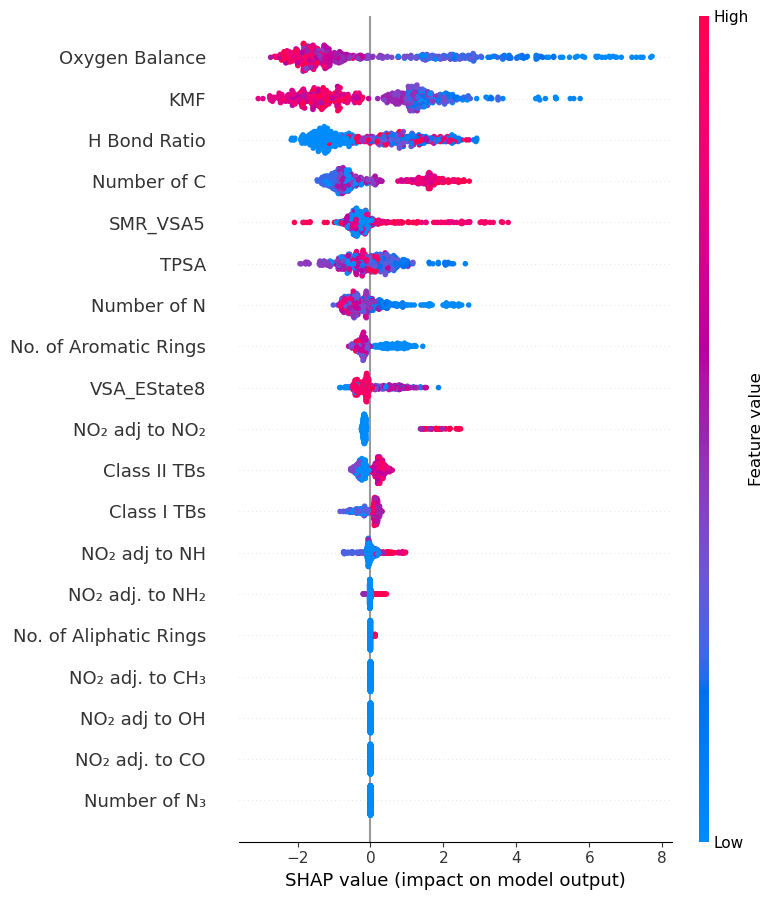

In [41]:
# 4 class
explainer = shap.TreeExplainer(lgb_models['quaternary'])
shap_values = explainer(X)
for i in range(0,4):
    shap.summary_plot(shap_values[:,:,i], X)

### Feature Importance Plots

In [43]:
def save_feature_importance(model, feature_names, filename):
    
    importances = model.feature_importances_
    normalized_importances = importances / np.sum(importances)
    scaled_importances = (importances-importances.min())/(importances.max()-importances.min())
    
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Normalized Importance':normalized_importances,
        'Scaled Importance':scaled_importances
    })
    
    fi_df = fi_df.sort_values(by='Importance', ascending=True)
    fi_df.to_csv(filename, index=False, encoding = "utf-8-sig")
    print(f"Saved feature importances to {filename}")

In [44]:
save_feature_importance(rf_models['binary'], X.columns, 'RedFeatOutput/binary_rf_imp_red_feat_corr_file.csv')
save_feature_importance(rf_models['tertiary'], X.columns, 'RedFeatOutput/tertiary_rf_imp_red_feat_corr_file.csv')
save_feature_importance(rf_models['quaternary'], X.columns, 'RedFeatOutput/quaternary_rf_imp_red_feat_corr_file.csv')
save_feature_importance(rf_models['quintenary'], X.columns, 'RedFeatOutput/quintenary_rf_imp_red_feat_corr_file.csv')

Saved feature importances to RedFeatOutput/binary_rf_imp_red_feat_corr_file.csv
Saved feature importances to RedFeatOutput/tertiary_rf_imp_red_feat_corr_file.csv
Saved feature importances to RedFeatOutput/quaternary_rf_imp_red_feat_corr_file.csv
Saved feature importances to RedFeatOutput/quintenary_rf_imp_red_feat_corr_file.csv


In [45]:
feature_groups = ['Vibrational Up-Pumping Inspired', 
                  'EM Inspired',
                  'EM Inspired',
                  'Structure Design Inspired',
                  'Vibrational Up-Pumping Inspired',
                  'EM Inspired',
                  'Vibrational Up-Pumping Inspired',
                  'Vibrational Up-Pumping Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired',
                  'Structure Design Inspired']
                  

In [64]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [46]:
def plot_feat_imp(model, feature_names, feature_groups, model_name, scale="scale"):
    importances = model.feature_importances_
    normalized_importances = importances / np.sum(importances)
    scaled_importances = (importances-importances.min())/(importances.max()-importances.min())
    if scale == "scale":
        use = scaled_importances
        txt = "Scaled"
    elif scale == "norm":
        use = normalized_importances
        txt = "Normalized"
    elif scale == None:
        use = importances
        txt = ""
    
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': use,
        'Group':feature_groups
    })
    fi_df = fi_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 6))
    plt.rcParams['font.family'] = 'DejaVu Sans'
    sns.set(style="whitegrid")
    unique_groups = fi_df['Group'].unique()
    palette = {'EM Inspired':'#2784F5',
               'Vibrational Up-Pumping Inspired':'#6ABD6D',
               'Structure Design Inspired':'#FC4C4C'}
    sns.barplot(
        data=fi_df,
        x='Feature',
        y='Importance',
        hue='Group',
        dodge=False,
        palette=palette
    )
    plt.xticks(fontname='DejaVu Sans', rotation=80)
    plt.title(txt+" "+"Feature Importances - " + model_name)
    plt.tight_layout()
    plt.legend(title="Feature Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(False)
    plt.show()

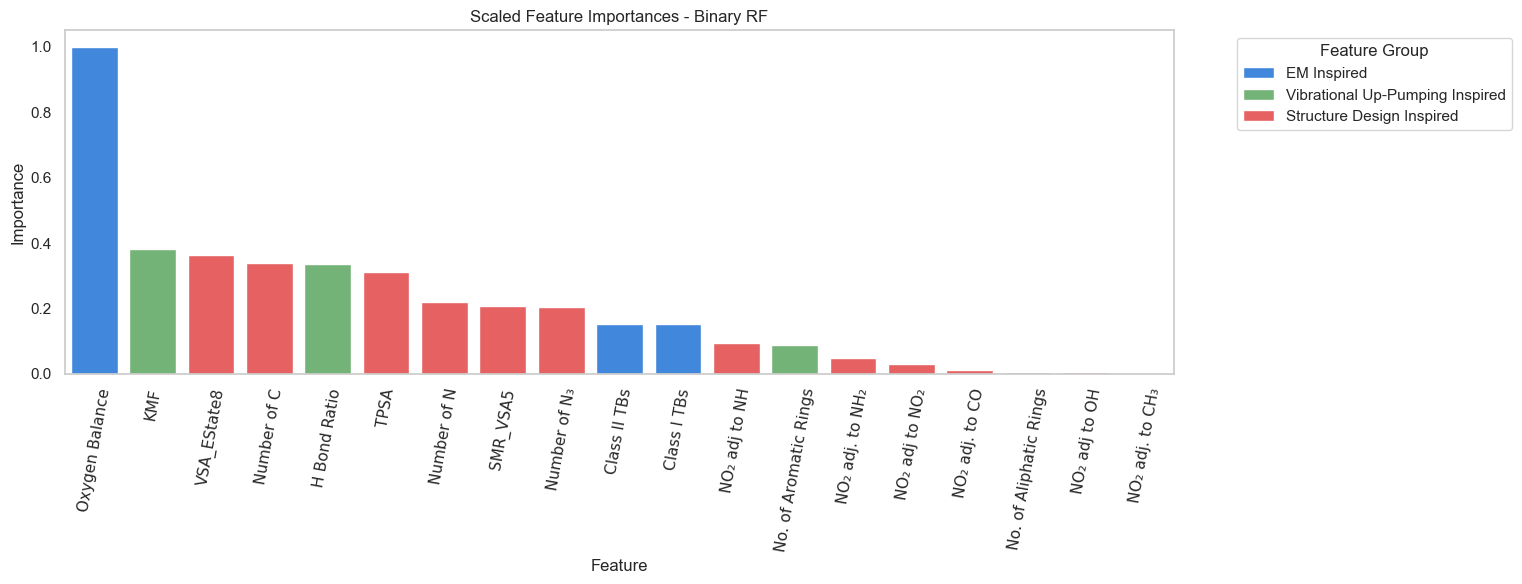

In [47]:
plot_feat_imp(rf_models['binary'], X.columns, feature_groups, model_name = 'Binary RF')

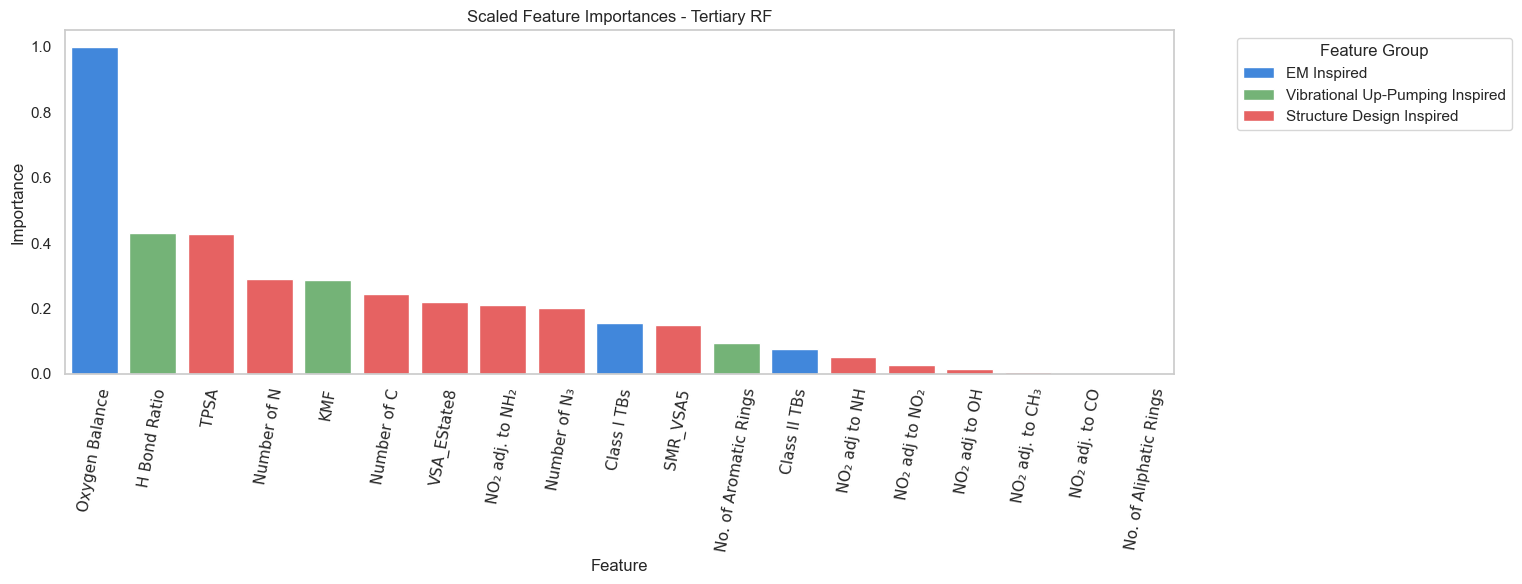

In [48]:
plot_feat_imp(rf_models['tertiary'], X.columns, feature_groups, model_name = 'Tertiary RF')

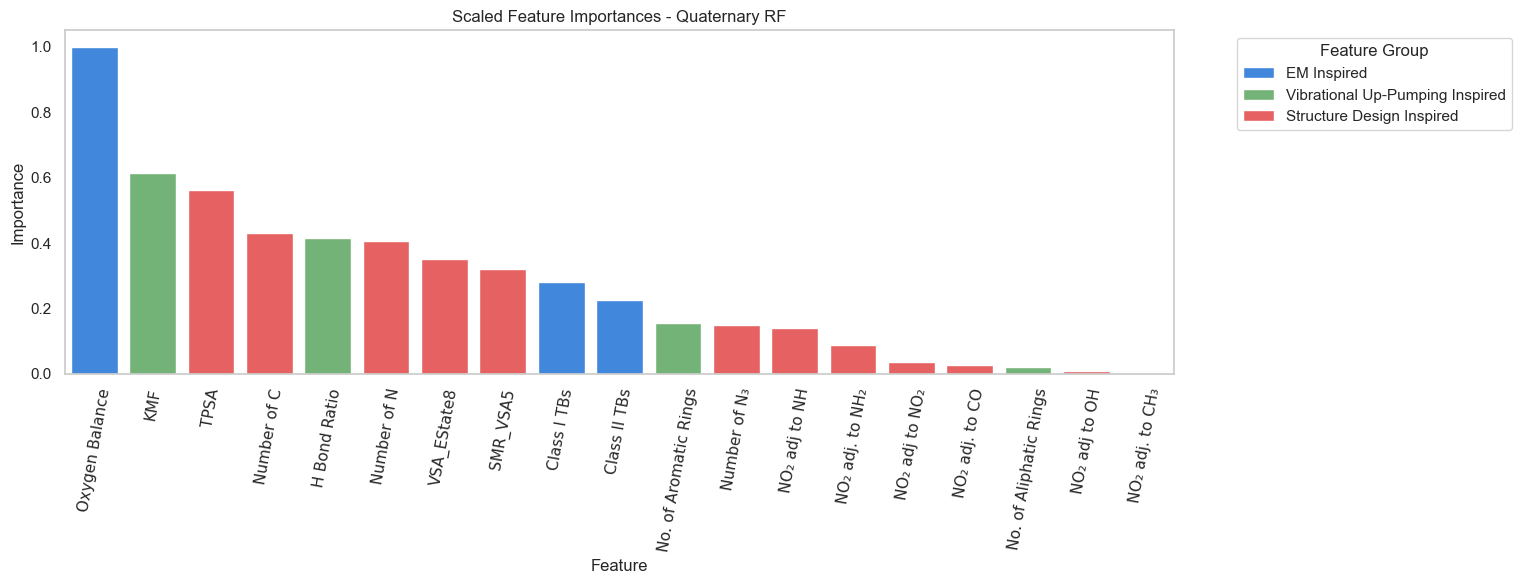

In [49]:
plot_feat_imp(rf_models['quaternary'], X.columns, feature_groups, model_name = 'Quaternary RF')

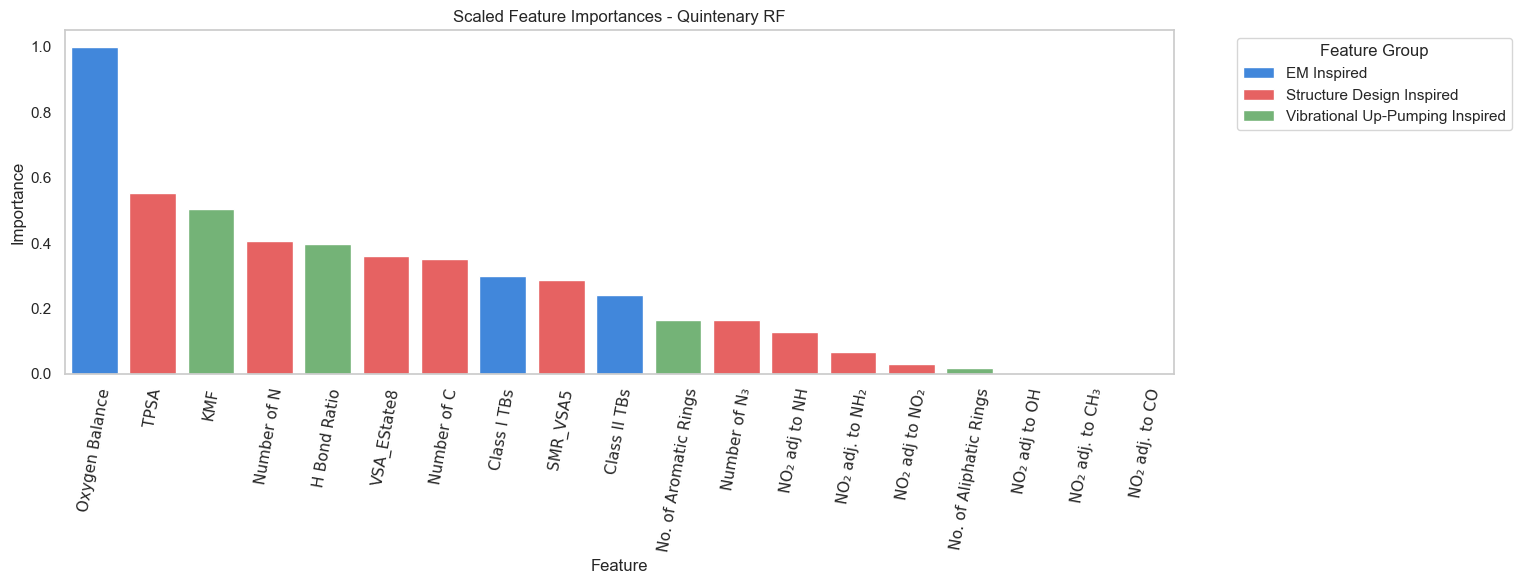

In [50]:
plot_feat_imp(rf_models['quintenary'], X.columns, feature_groups, model_name = 'Quintenary RF')

In [51]:
save_feature_importance(lgb_models['binary'], X.columns, 'RedFeatOutput/binary_gbm_imp_red_feat_corr_file.csv')
save_feature_importance(lgb_models['tertiary'], X.columns, 'RedFeatOutput/tertiary_gbm_imp_red_feat_corr_file.csv')
save_feature_importance(lgb_models['quaternary'], X.columns, 'RedFeatOutput/quaternary_gbm_imp_red_feat_corr_file.csv')
save_feature_importance(lgb_models['quintenary'], X.columns, 'RedFeatOutput/quintenary_gbm_imp_red_feat_corr_file.csv')

Saved feature importances to RedFeatOutput/binary_gbm_imp_red_feat_corr_file.csv
Saved feature importances to RedFeatOutput/tertiary_gbm_imp_red_feat_corr_file.csv
Saved feature importances to RedFeatOutput/quaternary_gbm_imp_red_feat_corr_file.csv
Saved feature importances to RedFeatOutput/quintenary_gbm_imp_red_feat_corr_file.csv


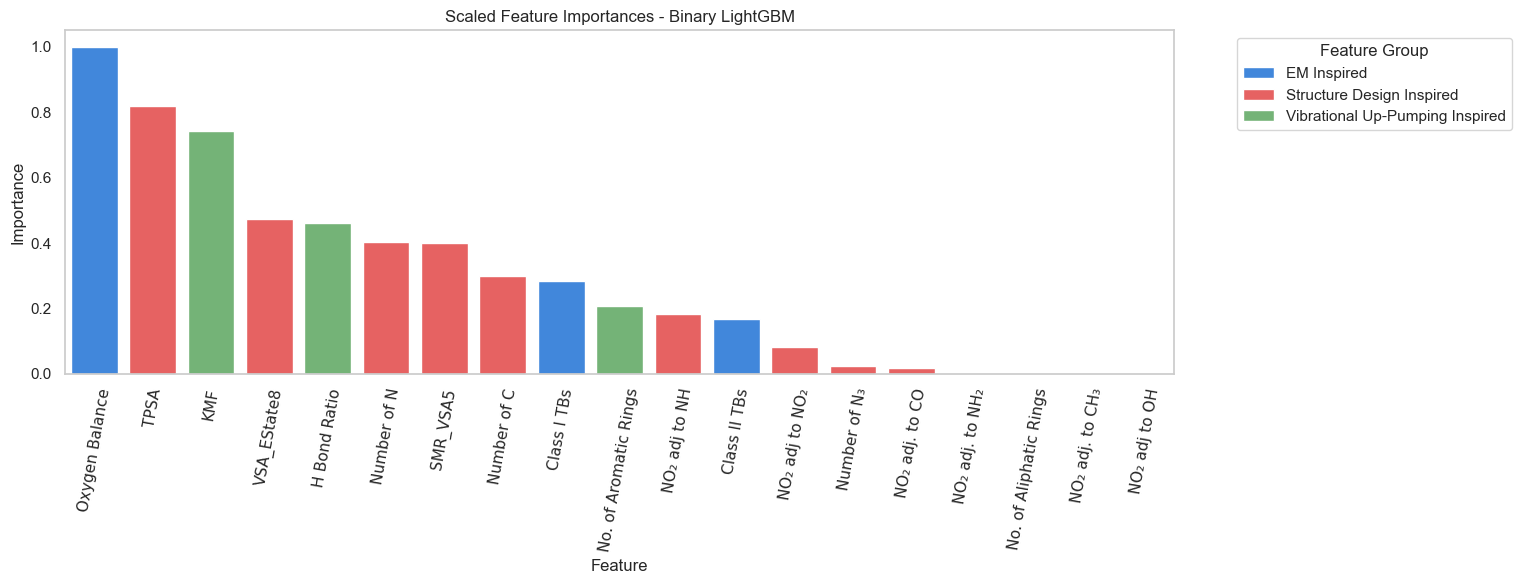

In [52]:
plot_feat_imp(lgb_models['binary'], X.columns, feature_groups, model_name = 'Binary LightGBM')

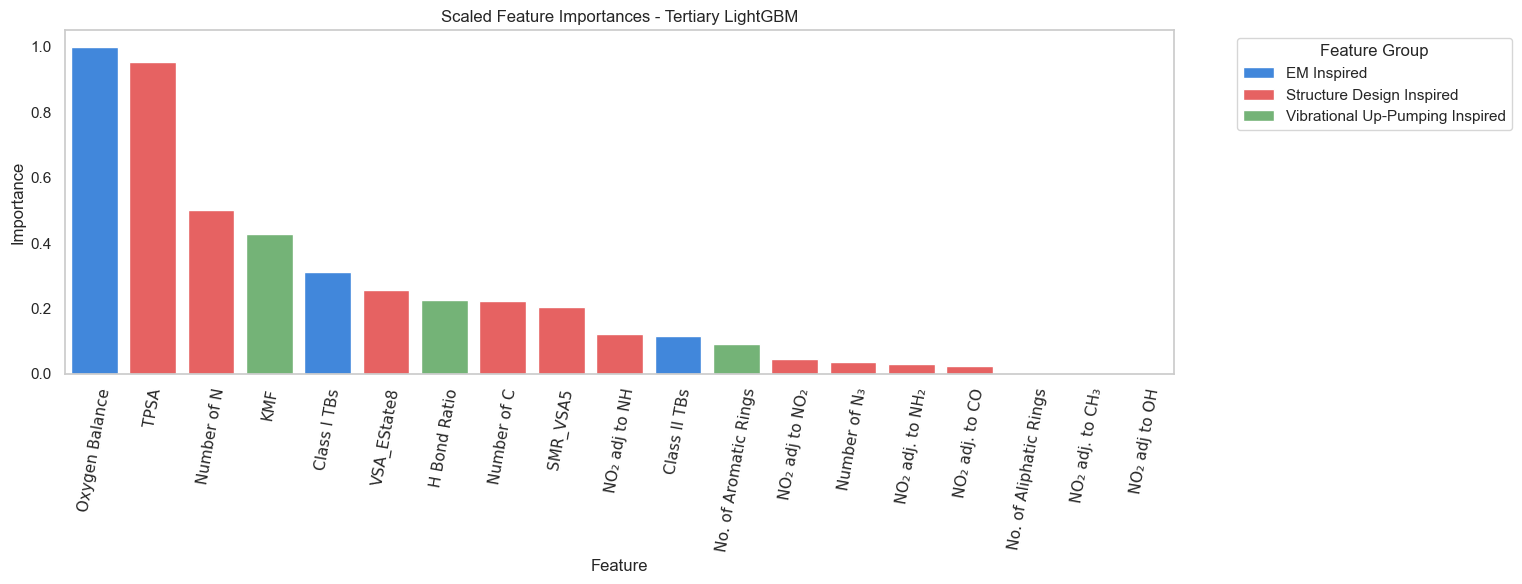

In [53]:
plot_feat_imp(lgb_models['tertiary'], X.columns, feature_groups, model_name = 'Tertiary LightGBM')

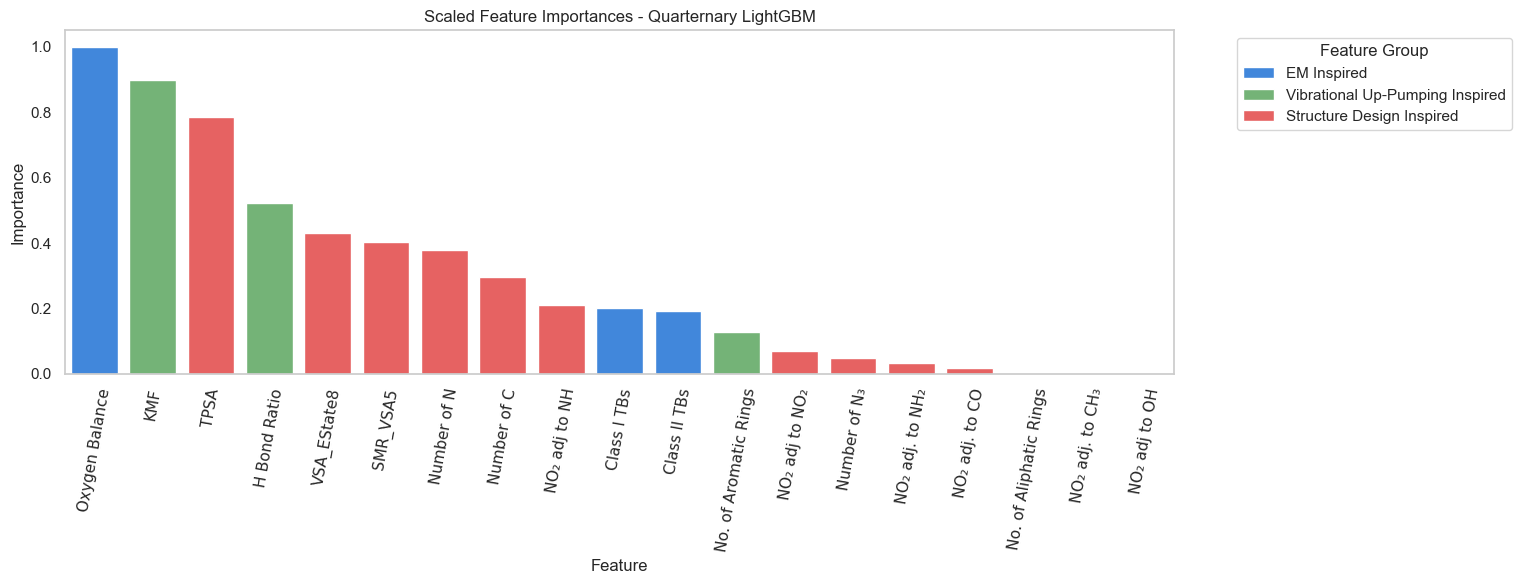

In [54]:
plot_feat_imp(lgb_models['quaternary'], X.columns, feature_groups, model_name = 'Quarternary LightGBM')

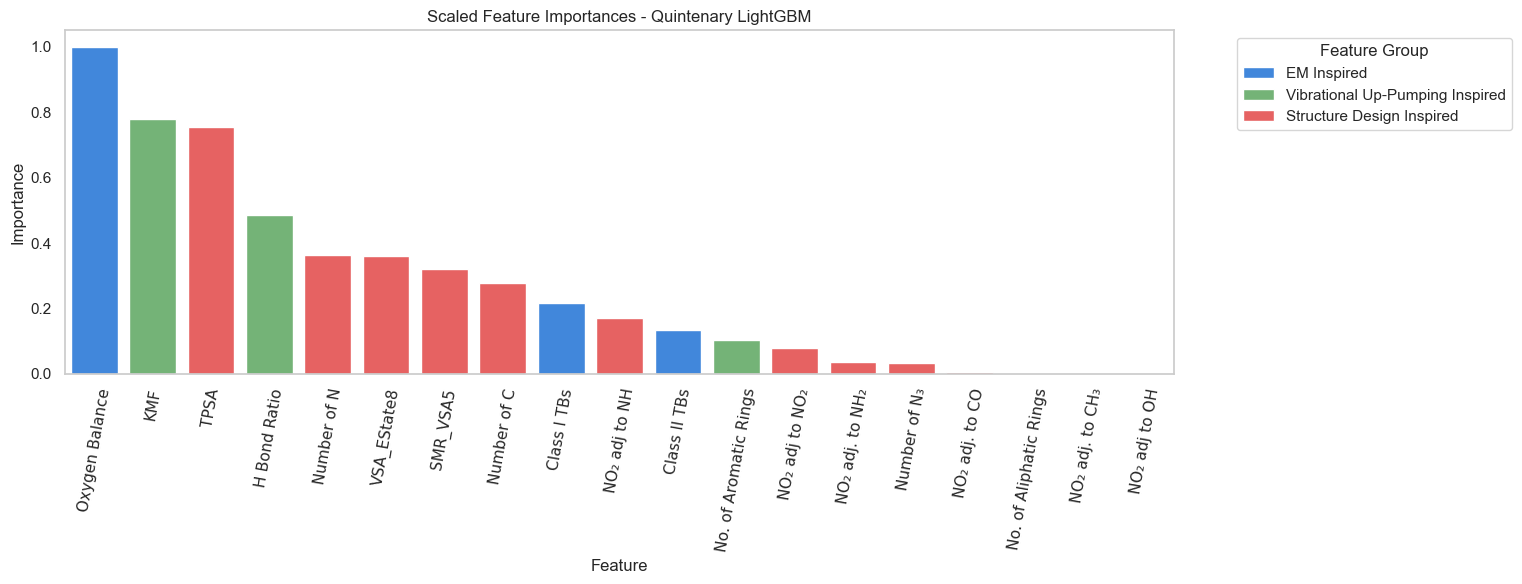

In [55]:
plot_feat_imp(lgb_models['quintenary'], X.columns, feature_groups, model_name = 'Quintenary LightGBM')

### Save models

In [46]:
import joblib
import os

In [44]:
model_dicts = {
    "logreg": logreg_models,
    "svc": svc_models,
    "rf": rf_models,
    "lgb": lgb_models
}

In [47]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

In [48]:
for model_type, models in model_dicts.items():
    for name, model in models.items():
        filename = f"{model_type}_{name}.joblib"
        joblib.dump(model, os.path.join(save_dir, filename))

In [49]:
# Save as dicts instead of individual models

In [50]:
for model_type, models in model_dicts.items():
    filename = os.path.join(save_dir, f"{model_type}_models.joblib")
    joblib.dump(models, filename)

In [51]:
# Save column scaler
joblib.dump(transformer, "saved_models/column_transformer.joblib")

['saved_models/column_transformer.joblib']